In [1]:
import itertools
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.tree._tree import TREE_LEAF
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score, roc_auc_score, accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from scipy.stats import ttest_ind
from tqdm import tqdm

In [2]:
headers=["Status of existing checking account", "Duration in month", "Credit history",
         "Purpose", "Credit amount", "Savings account/bonds", "Present employment since",
         "Installment rate in percentage of disposable income", "Personal status and sex",
         "Other debtors / guarantors", "Present residence since", "Property", "age",
        "Other installment plans", "Housing", "Number of existing credits at this bank",
        "Job", "Number of people being liable to provide maintenance for", "Telephone", "foreign worker","Cost Matrix(Risk)"]
german = pd.read_csv("german.data", sep='\s+', names=headers)
german

,Status of existing checking account,Duration in month,Credit history,Purpose,Credit amount,Savings account/bonds,Present employment since,Installment rate in percentage of disposable income,Personal status and sex,Other debtors / guarantors,...,Property,age,Other installment plans,Housing,Number of existing credits at this bank,Job,Number of people being liable to provide maintenance for,Telephone,foreign worker,Cost Matrix(Risk)
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,A14,12,A32,A42,1736,A61,A74,3,A92,A101,...,A121,31,A143,A152,1,A172,1,A191,A201,1
996,A11,30,A32,A41,3857,A61,A73,4,A91,A101,...,A122,40,A143,A152,1,A174,1,A192,A201,1
997,A14,12,A32,A43,804,A61,A75,4,A93,A101,...,A123,38,A143,A152,1,A173,1,A191,A201,1
998,A11,45,A32,A43,1845,A61,A73,4,A93,A101,...,A124,23,A143,A153,1,A173,1,A192,A201,2


In [3]:
german.isna().any()

Status of existing checking account                         False
Duration in month                                           False
Credit history                                              False
Purpose                                                     False
Credit amount                                               False
Savings account/bonds                                       False
Present employment since                                    False
Installment rate in percentage of disposable income         False
Personal status and sex                                     False
Other debtors / guarantors                                  False
Present residence since                                     False
Property                                                    False
age                                                         False
Other installment plans                                     False
Housing                                                     False
Number of 

In [4]:
# separate race, sex and age attributes from training set
german_sex = german["Personal status and sex"]
german_race = german["foreign worker"]
german_age = german["age"]

# transform Personal status and sex to binary feature
german = german.drop(columns=["Personal status and sex", "foreign worker", "age"])
german_sex = german_sex.map({"A91": "Male", "A92":"Female", "A93": "Male", "A94": "Male", "A95": "Female"})
german_race = german_race.map({"A201": "Non_White", "A202": "White"})
german_sex

0        Male
1      Female
2        Male
3        Male
4        Male
        ...  
995    Female
996      Male
997      Male
998      Male
999      Male
Name: Personal status and sex, Length: 1000, dtype: object

In [5]:
german_sexrace = pd.concat([german_sex, german_race], axis=1)
german_sex_race = german_sexrace[['Personal status and sex', 'foreign worker']].agg('-'.join, axis=1)
german_sex_race

0        Male-Non_White
1      Female-Non_White
2        Male-Non_White
3        Male-Non_White
4        Male-Non_White
             ...       
995    Female-Non_White
996      Male-Non_White
997      Male-Non_White
998      Male-Non_White
999      Male-Non_White
Length: 1000, dtype: object

In [6]:
german_y = german["Cost Matrix(Risk)"]
german_y = german_y.map({1:1, 2:0})
german_X = german.drop(columns=["Cost Matrix(Risk)"])

In [7]:
german_cat_X = pd.get_dummies(german_X)
german_cat_X

,Duration in month,Credit amount,Installment rate in percentage of disposable income,Present residence since,Number of existing credits at this bank,Number of people being liable to provide maintenance for,Status of existing checking account_A11,Status of existing checking account_A12,Status of existing checking account_A13,Status of existing checking account_A14,...,Other installment plans_A143,Housing_A151,Housing_A152,Housing_A153,Job_A171,Job_A172,Job_A173,Job_A174,Telephone_A191,Telephone_A192
0,6,1169,4,4,2,1,1,0,0,0,...,1,0,1,0,0,0,1,0,0,1
1,48,5951,2,2,1,1,0,1,0,0,...,1,0,1,0,0,0,1,0,1,0
2,12,2096,2,3,1,2,0,0,0,1,...,1,0,1,0,0,1,0,0,1,0
3,42,7882,2,4,1,2,1,0,0,0,...,1,0,0,1,0,0,1,0,1,0
4,24,4870,3,4,2,2,1,0,0,0,...,1,0,0,1,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,12,1736,3,4,1,1,0,0,0,1,...,1,0,1,0,0,1,0,0,1,0
996,30,3857,4,4,1,1,1,0,0,0,...,1,0,1,0,0,0,0,1,0,1
997,12,804,4,4,1,1,0,0,0,1,...,1,0,1,0,0,0,1,0,1,0
998,45,1845,4,4,1,1,1,0,0,0,...,1,0,0,1,0,0,1,0,0,1


In [8]:
# make a train and test split with same proportional size as Adult dataset
german_train_cat_X, german_test_cat_X, german_train_y, german_test_y= train_test_split(german_cat_X, german_y, test_size=1/3, random_state=42)

# also for the sensitive attributes with same random_state
german_train_sex, german_test_sex, german_train_y, german_test_y = train_test_split(german_sex, german_y, test_size=1/3, random_state=42)
german_train_race, german_test_race, german_train_y, german_test_y = train_test_split(german_race, german_y, test_size=1/3, random_state=42)
german_train_age, german_test_age, german_train_y, german_test_y = train_test_split(german_age, german_y, test_size=1/3, random_state=42)
german_train_sex_race, german_test_sex_race, german_train_y, german_test_y = train_test_split(german_sex_race, german_y, test_size=1/3, random_state=42)



In [9]:
german_test_sex_race.value_counts()

Male-Non_White      229
Female-Non_White     95
Male-White            8
Female-White          2
dtype: int64

## Tree construction

In [10]:
# construct decision tree
tree = DecisionTreeClassifier(random_state=42)

parameter_grid={"criterion":["entropy", "gini"], "max_depth":[2, 3, 4], 
                "max_features":["sqrt", None, "log2"], 
                "max_leaf_nodes":[3, 4, 5, 6, 7, 8, 9, 10, 11, 12], "ccp_alpha": [0.01, 0.05, 0.1],
               "min_impurity_decrease": [0.001, 0.005, 0.01, 0.025, 0.05]}
tree_cv = GridSearchCV(tree, param_grid=parameter_grid, scoring='balanced_accuracy', n_jobs=2, cv=3, verbose=1)
tree_cv.fit(german_train_cat_X, german_train_y)
best_tree = tree_cv.best_estimator_
best_tree

Fitting 3 folds for each of 2700 candidates, totalling 8100 fits


DecisionTreeClassifier(ccp_alpha=0.01, max_depth=4, max_leaf_nodes=7,
                       min_impurity_decrease=0.001, random_state=42)

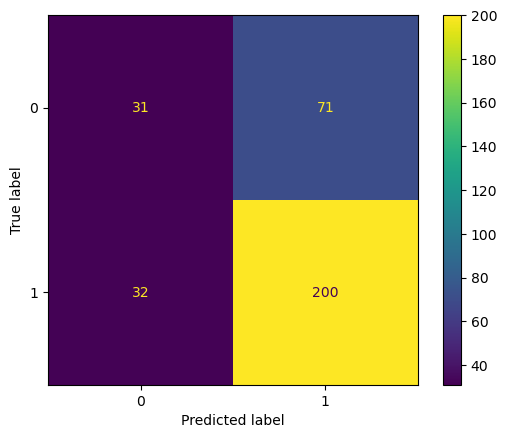

In [11]:
# confusion matrix / performance on testset
y_pred = best_tree.predict(german_test_cat_X)
cm = confusion_matrix(german_test_y, y_pred, labels=best_tree.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_tree.classes_)
disp.plot()

In [12]:
print(f"Balanced accuracy on test set: {balanced_accuracy_score(german_test_y, y_pred)}")
print(f"ROC-AUC score on test set: {roc_auc_score(german_test_y, y_pred)}")
print(f"Accuracy score: {accuracy_score(german_test_y, y_pred)}")

Balanced accuracy on test set: 0.5829952670723462
ROC-AUC score on test set: 0.5829952670723462
Accuracy score: 0.6916167664670658


In [13]:
column_names = [name for name in german_train_cat_X.columns]
print(export_text(best_tree, feature_names=column_names))

|--- Status of existing checking account_A14 <= 0.50
|   |--- Duration in month <= 33.00
|   |   |--- Purpose_A40 <= 0.50
|   |   |   |--- class: 1
|   |   |--- Purpose_A40 >  0.50
|   |   |   |--- Credit history_A34 <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- Credit history_A34 >  0.50
|   |   |   |   |--- class: 1
|   |--- Duration in month >  33.00
|   |   |--- class: 0
|--- Status of existing checking account_A14 >  0.50
|   |--- class: 1



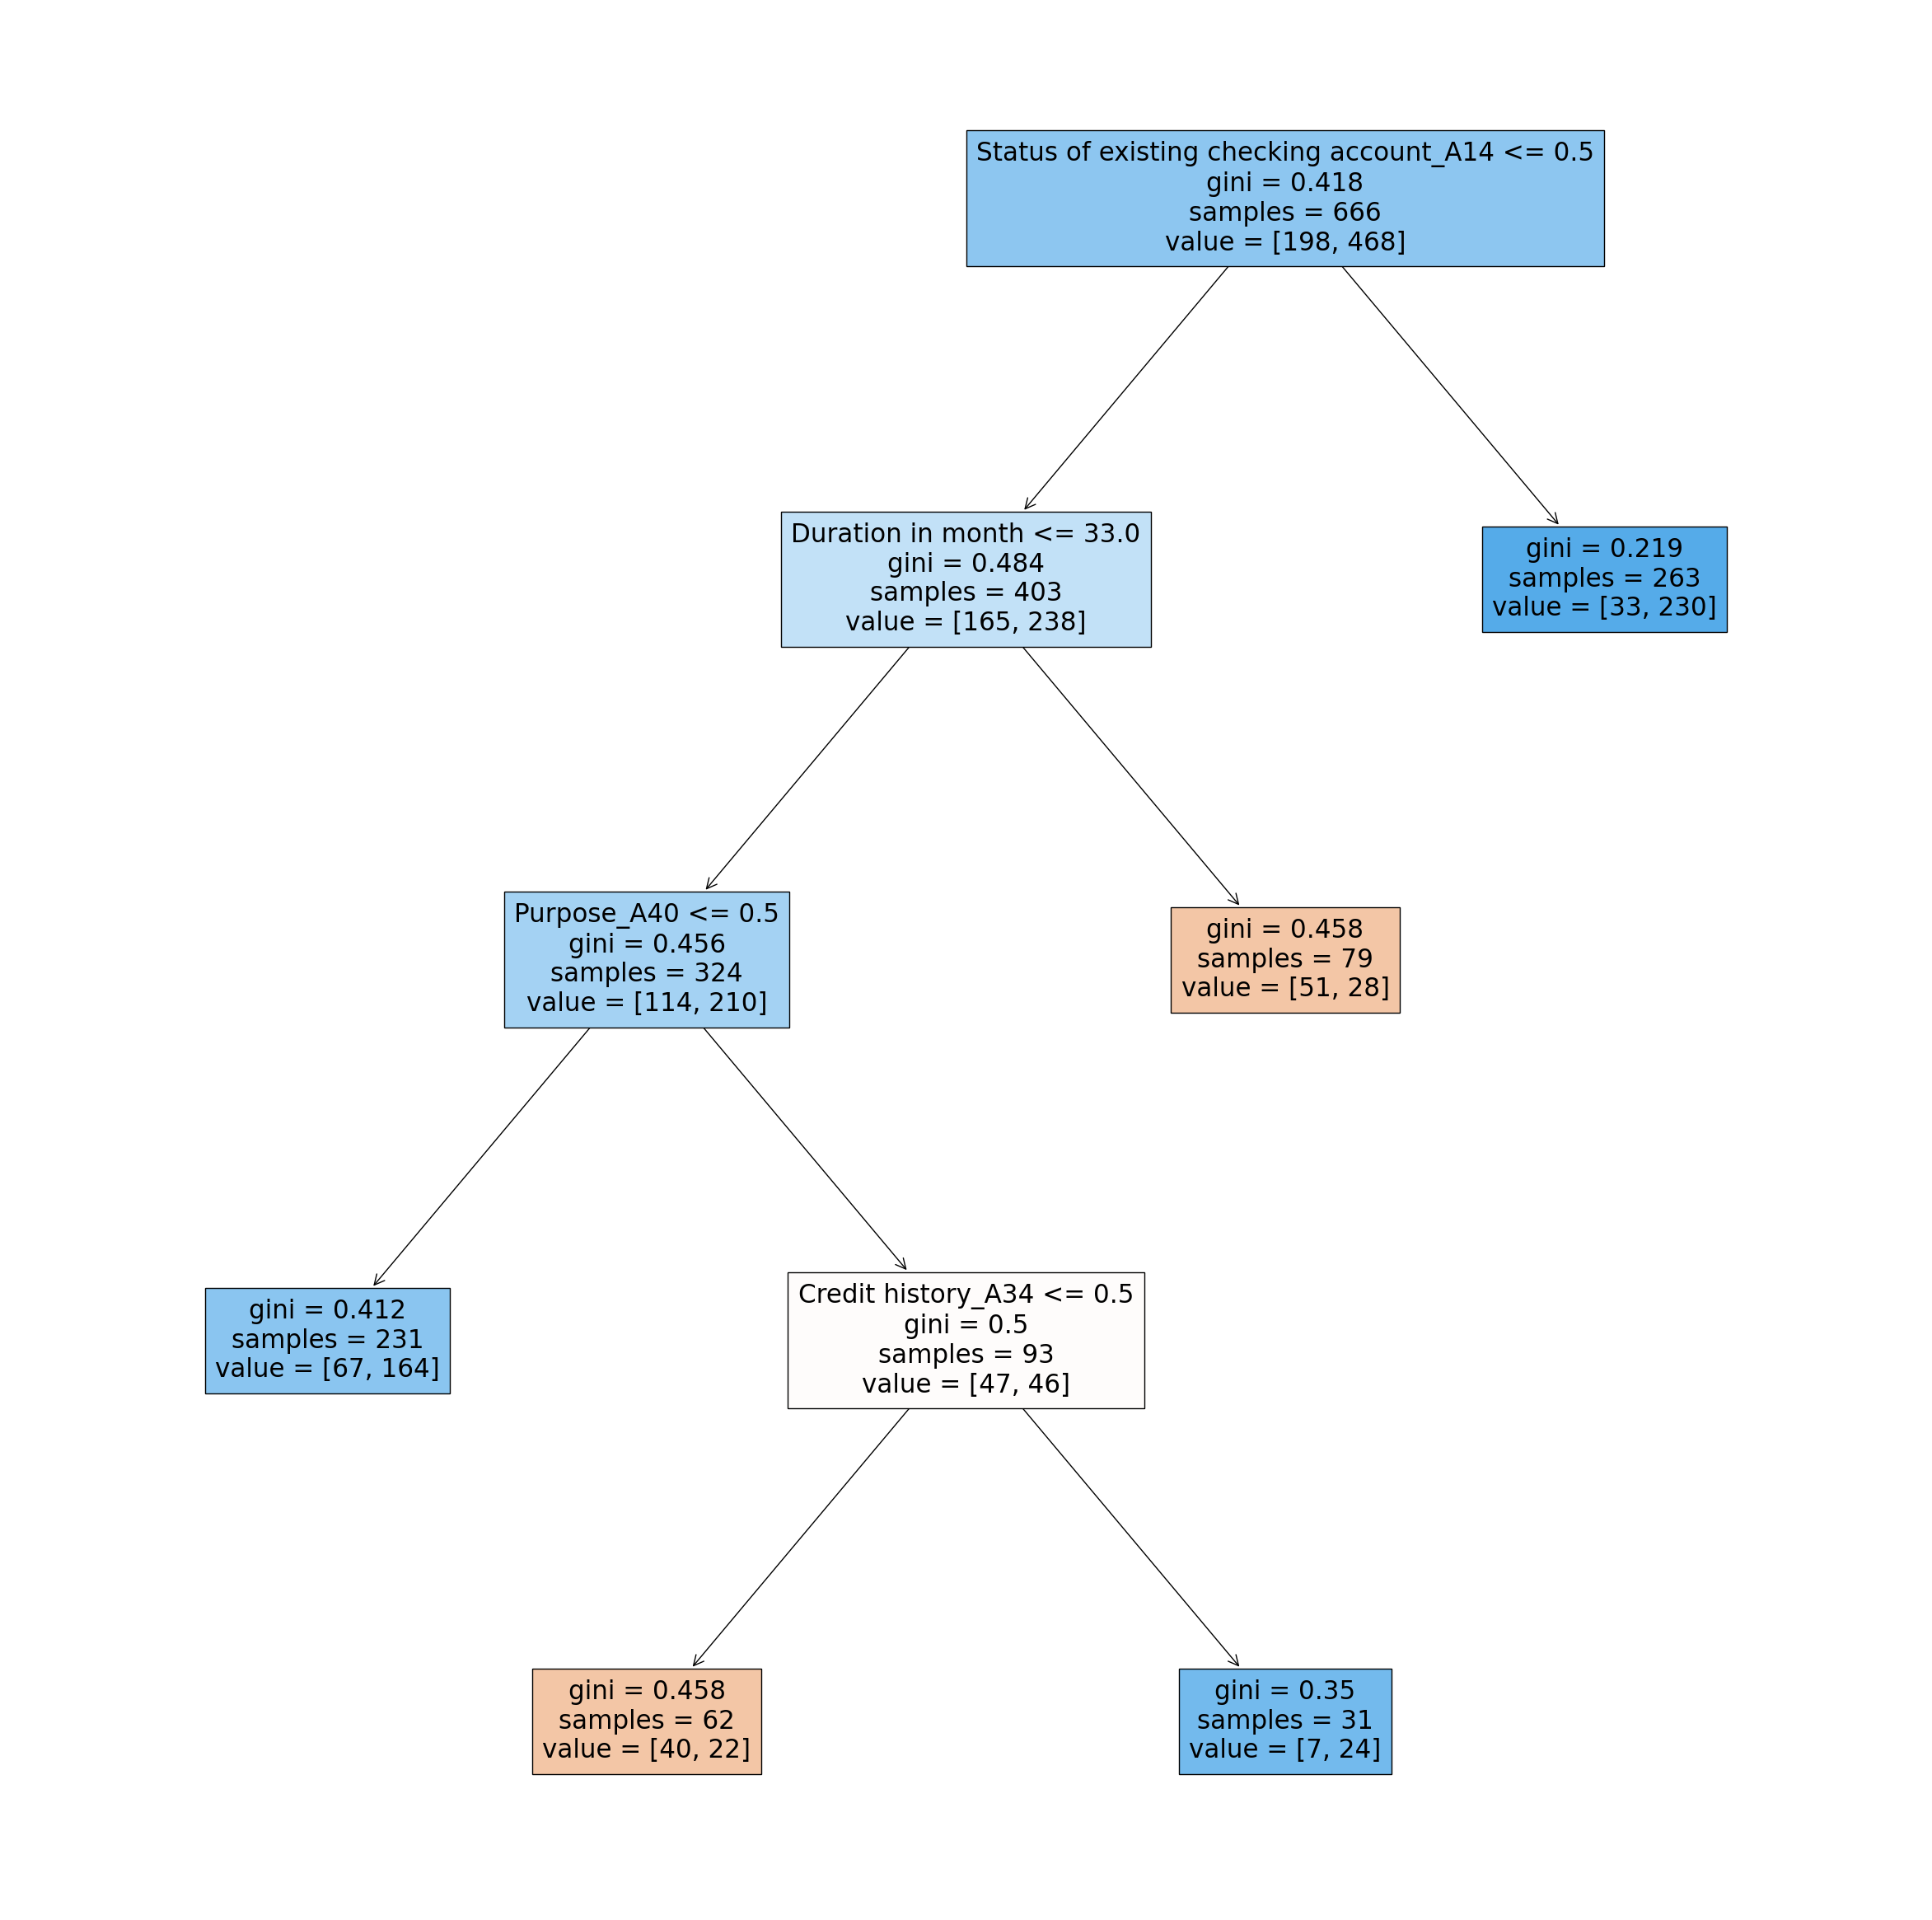

In [15]:
plt.figure(figsize=(30, 30))
plot_tree(best_tree, feature_names=german_train_cat_X.columns, filled=True)
plt.show()

In [14]:
# taken from: https://stackoverflow.com/a/51398390
def is_leaf(inner_tree, index):
    # Check whether node is leaf node
    return (inner_tree.children_left[index] == TREE_LEAF and 
            inner_tree.children_right[index] == TREE_LEAF)

def prune_index(inner_tree, decisions, index=0):
    # Start pruning from the bottom - if we start from the top, we might miss
    # nodes that become leaves during pruning.
    # Do not use this directly - use prune_duplicate_leaves instead.
    if not is_leaf(inner_tree, inner_tree.children_left[index]):
        prune_index(inner_tree, decisions, inner_tree.children_left[index])
    if not is_leaf(inner_tree, inner_tree.children_right[index]):
        prune_index(inner_tree, decisions, inner_tree.children_right[index])

    # Prune children if both children are leaves now and make the same decision:     
    if (is_leaf(inner_tree, inner_tree.children_left[index]) and
        is_leaf(inner_tree, inner_tree.children_right[index]) and
        (decisions[index] == decisions[inner_tree.children_left[index]]) and 
        (decisions[index] == decisions[inner_tree.children_right[index]])):
        # turn node into a leaf by "unlinking" its children
        inner_tree.children_left[index] = TREE_LEAF
        inner_tree.children_right[index] = TREE_LEAF
        ##print("Pruned {}".format(index))

def prune_duplicate_leaves(mdl):
    # Remove leaves if both 
    decisions = mdl.tree_.value.argmax(axis=2).flatten().tolist() # Decision for each node
    prune_index(mdl.tree_, decisions)
    
# pruning happens in-place
prune_duplicate_leaves(best_tree)

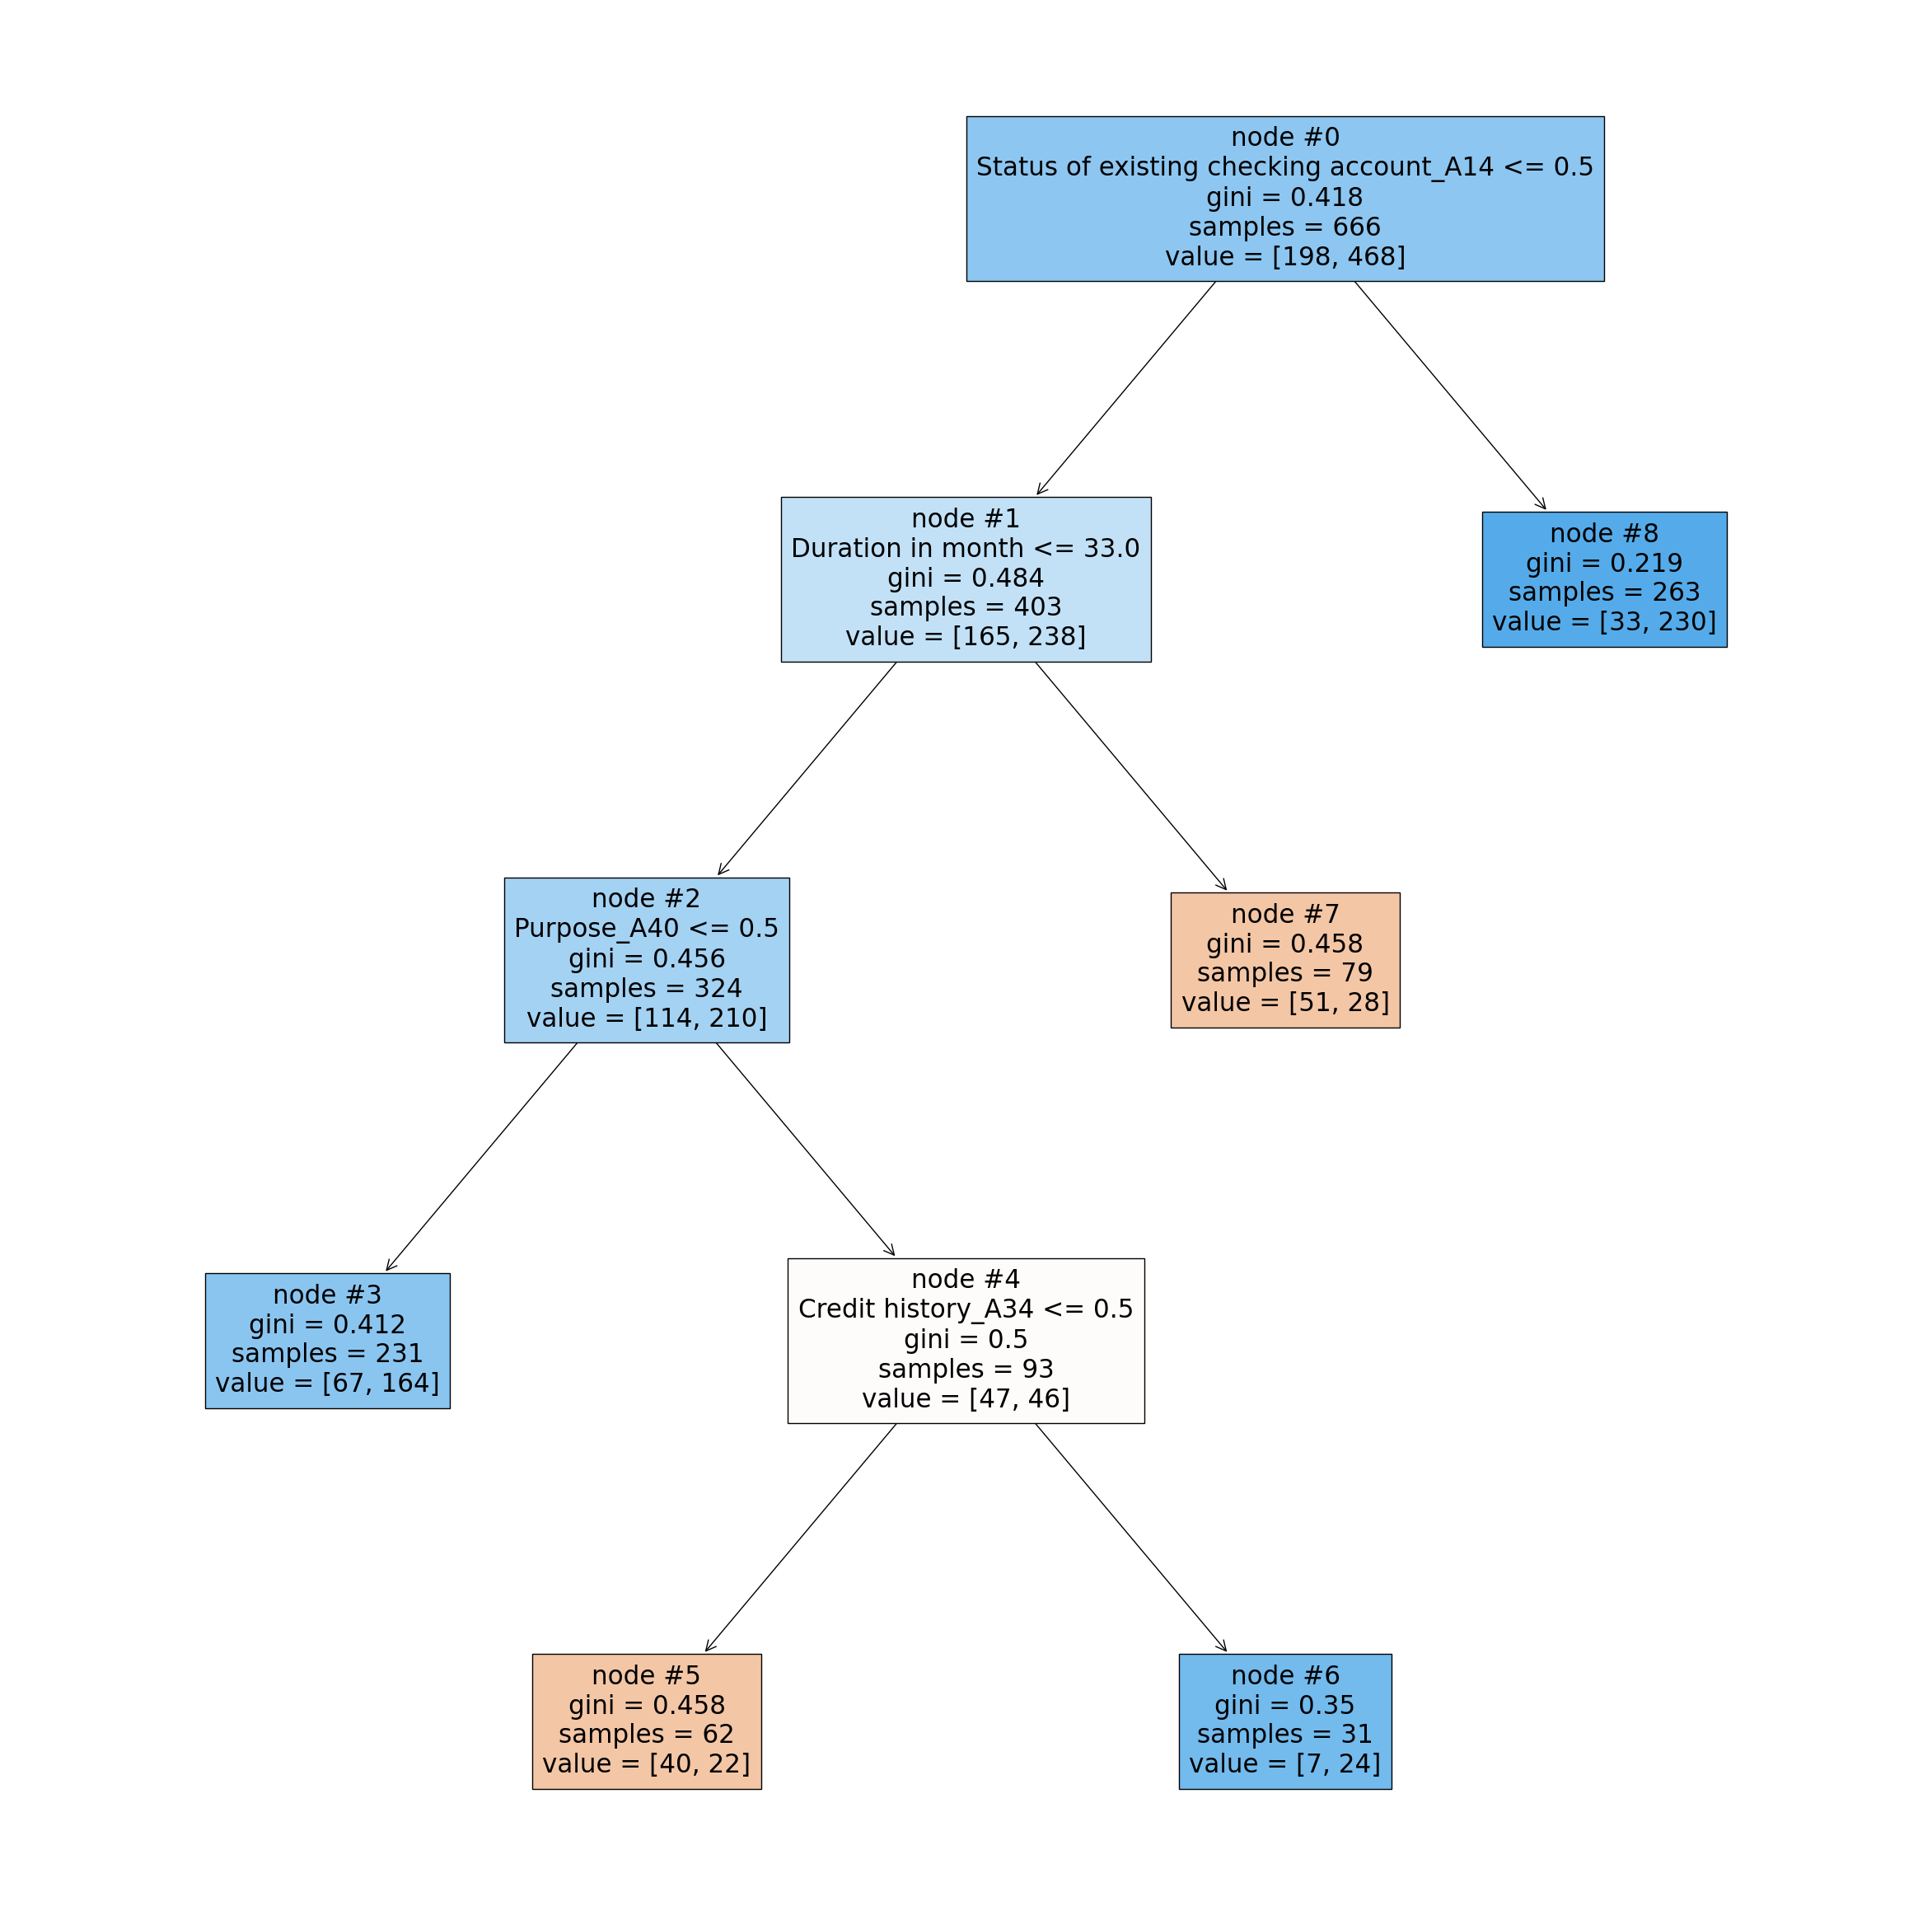

In [17]:
plt.figure(figsize=(30,30))
plot_tree(best_tree, feature_names=german_train_cat_X.columns, filled=True, node_ids=True)
plt.savefig("germantree", dpi=300)
plt.show()

In [15]:
# taken from: https://stackoverflow.com/a/56427596
n_nodes = best_tree.tree_.node_count
children_left = best_tree.tree_.children_left
children_right = best_tree.tree_.children_right
feature = best_tree.tree_.feature
threshold = best_tree.tree_.threshold

def find_path(node_numb, path, x):
    path.append(node_numb)
    if node_numb == x:
        return True
    left = False
    right = False
    if (children_left[node_numb] !=-1):
        left = find_path(children_left[node_numb], path, x)
    if (children_right[node_numb] !=-1):
        right = find_path(children_right[node_numb], path, x)
    if left or right :
        return True
    path.remove(node_numb)
    return False


def get_rule(df_name, path, column_names):
    mask = '('
    for index, node in enumerate(path):
        # check if we are not in the leaf
        if index!=len(path)-1:
            # under or over the threshold?
            if (children_left[node] == path[index+1]):
                mask += f"{df_name}['{column_names[feature[node]]}']<= {threshold[node]}\t "
            else:
                mask += f"{df_name}['{column_names[feature[node]]}']> {threshold[node]} \t "
                
    # insert the & at the right places
    mask = mask.replace("\t", "&", mask.count("\t") - 1)
    mask = mask.replace("\t", "")
    mask += ")"
    return mask



In [16]:
# Leaves
leave_id = best_tree.apply(german_test_cat_X)

paths = {}
for leaf in np.unique(leave_id):
    path_leaf = []
    find_path(0, path_leaf, leaf)
    paths[leaf] = np.unique(np.sort(path_leaf))

rules = {}
for key in paths:
    rules[key] = get_rule("german_test_cat_X", paths[key], column_names)
    
rules

{3: "(german_test_cat_X['Status of existing checking account_A14']<= 0.5& german_test_cat_X['Duration in month']<= 33.0& german_test_cat_X['Purpose_A40']<= 0.5 )",
 5: "(german_test_cat_X['Status of existing checking account_A14']<= 0.5& german_test_cat_X['Duration in month']<= 33.0& german_test_cat_X['Purpose_A40']> 0.5 & german_test_cat_X['Credit history_A34']<= 0.5 )",
 6: "(german_test_cat_X['Status of existing checking account_A14']<= 0.5& german_test_cat_X['Duration in month']<= 33.0& german_test_cat_X['Purpose_A40']> 0.5 & german_test_cat_X['Credit history_A34']> 0.5  )",
 7: "(german_test_cat_X['Status of existing checking account_A14']<= 0.5& german_test_cat_X['Duration in month']> 33.0  )",
 8: "(german_test_cat_X['Status of existing checking account_A14']> 0.5  )"}

## PAFER

In [17]:
def positive_rules (tree, rules):
    """From the extracted rules, return those that have a favorable classification

    Arg:
        tree: The tree classification object from which the rules are extracted. 
        rules: Dict of which the values are rule strings.

    Returns:
        A list of all the rules that classify favorably"""

    # only those rules are added for which the majority of individuals in the node is at index 1 # index 1 corresponds to class 1
    return [rule for node_id, rule in rules.items() if np.argmax(tree.tree_.value[node_id][0])]

positive_rules(best_tree, rules)

["(german_test_cat_X['Status of existing checking account_A14']<= 0.5& german_test_cat_X['Duration in month']<= 33.0& german_test_cat_X['Purpose_A40']<= 0.5 )",
 "(german_test_cat_X['Status of existing checking account_A14']<= 0.5& german_test_cat_X['Duration in month']<= 33.0& german_test_cat_X['Purpose_A40']> 0.5 & german_test_cat_X['Credit history_A34']> 0.5  )",
 "(german_test_cat_X['Status of existing checking account_A14']> 0.5  )"]

In [18]:
def oracle(dataset, sens_dataset, rule, s_i, mechanism=None, epsilon=0.05, delta=0.001):
    """Returns some (differentially privatised) statistics on the sensitive attribute for the specified dataframe and rule
    
    Args:
        df: The DataFrame that the developers own, which does not contain sensitive attributes.
            Used to calculate total quantities in (root) nodes.
        sens_dataset: A Series that the developers do not own, which contains the sensitive attributes. 
            Combined sensitive attributes should be encoded as a Series, e.g. Black-Female
        rule: The rule, as a string, for which the to estimate the sensitive attribute.
        s_i: The sensitive attribute, its name comes from the ith element in the set S of sensitive attributes.
            s_i should be in sens_dataset and should thus be a string. 
        mechanism: The privacy mechanism used on the returned counts. Can be one of "gaussian", "laplacian", "exponential", None. 
        epsilon: The privacy budget. Should be larger than 0.
        delta: The privacy margin. Ignored when mechanism is either laplacian or gaussian. Should be in (0, 1]. 
        
    Returns:
        The number of times s_i occurs in sens_dataset, privatised via the mechanism. 
        """
        
    # check epsilon and delta parameters
    if epsilon <= 0 or (mechanism == "gaussian" and (delta <= 0 or delta > 1 or epsilon > 1)):
        raise ValueError("The value of delta should be in (0,1] when using the gaussian mechanism")
    
    if not sens_dataset.isin([s_i]).any():
        raise KeyError("The requested sensitive attribute (s_i) is not in the sensitive dataframe (sens_dataset)")
        
    try:
        # the answer if no privacy mechanism is applied
        no_mechanism = sens_dataset.loc[dataset[pd.eval(rule)].index].value_counts(sort=False)[s_i]
        
    except KeyError:
        no_mechanism = 0
    
    if mechanism == "laplacian":
        # this is a histogram query so the l1-sensitivity = 1 as per Dwork & Roth 
        sensitivity = 1
        return no_mechanism + np.random.laplace(loc=0, scale=sensitivity / epsilon)
    
    elif mechanism == "gaussian":
        # this is a histogram query so the l2-sensitivity = 2 as per Dwork & Roth
        sensitivity = 2
        return no_mechanism + np.random.normal(loc=0, scale=2 * sensitivity**2 * np.log(1.25 / delta) / epsilon**2)
    
    elif mechanism == "exponential":
        # this query can only change by 1 if an instance is omitted so l1-sensitivity = 1
        sensitivity = 1
        
        # np.arange is [start, stop) so + 1 for entire possible range
        possible_values = np.arange(0, sens_dataset.loc[dataset[pd.eval(rule)].index].value_counts().to_numpy().sum() + 1)
        
        # the utility is higher when the value is closer to the actual value
        utility_scores = np.array([no_mechanism - abs(no_mechanism - value) for value in possible_values]) / 100
        probabilities = [np.exp(epsilon * score / (2 * sensitivity)) for score in utility_scores]
        
        # normalize probabilties to sum to 1
        probabilities /= np.linalg.norm(probabilities, ord=1)
        return np.random.choice(possible_values, p=probabilities)

    # if no mechanism is given, return the unprivatised cocunt
    return no_mechanism

oracle(german_test_cat_X, german_test_race, rules[3], "Non_White", "laplacian", epsilon=0.3, delta=0.1)

124.21426102529672

In [19]:
def statistical_parity(y_pred, sens_dataset):
    """Calculates Statistical Parity Ratio using the predictions and the actual sensitive feature values
    
    Args:
        y_pred: The predictions, should be of same size as sens_dataset.
        sens_dataset: The Series with the sensitive attributes.
        
    Returns:
        The true statistical parity ratio.
        """
    accept_rates = []
    
    for sens_attr in sorted(sens_dataset.unique()):
        accept_rates.append(np.sum((sens_dataset == sens_attr) & y_pred) / np.sum(sens_dataset == sens_attr))
        
    return min(accept_rates) / max(accept_rates)


def estimate_sp(pos_ruleset, dataset, sens_dataset, S, mechanism, epsilon, delta):
    """Returns the estimated Statistical Parity of a tree for a privacy mechanism
    
    Args:
        pos_ruleset: A list of rules that classify favorably in the tree. This is the representation of the
        (relevant parts of the) tree. 
        dataset: The DataFrame that the developers own that does not contain sensitive feature values.
        sens_dataset: The Series that contains the sensitive features, which the developers do not own.
        S: The set/list of sensitive attributes, should all be in the sens_dataset attribute.
        mechanism: The mechanism with which to privatise the queries. 
        epsilon: The privacy budget for the privacy mechanism. Should be larger than 0.
        delta: The privacy margin. Ignored when mechanism is either laplacian or gaussian. Should be in (0, 1].
        
    Returns:
        The statistical parity ratio for the specified pos_ruleset. 
        """
    
    poscounts_per_si = np.zeros(len(S))
    
    # the variable name of the current dataset is inferred from the ruleset
    datasetname = str(pos_ruleset[0].split('[')[0])[1:]
    
    # the base rule is a rule that includes all individuals, i.e. the condition is a tautology
    # in this case we select all rows that have a value that is in the set of possible values of the first column
    base_rule = f"({datasetname}[{datasetname}.columns[0]].isin({datasetname}[{datasetname}.columns[0]].unique()))"
    
    # query the size of each sensitive attribute in the dataset
    total_per_si = [oracle(dataset, sens_dataset, base_rule, s_i, mechanism, 0.5 * epsilon, delta) for s_i in S]
    
    valid, invalid = 0, 0
    # replace each invalid value with balanced totals
    for i, tot in enumerate(total_per_si):
        if tot < 0 or tot > len(sens_dataset):
            invalid += 1
            total_per_si[i] = (1 / len(S)) * len(sens_dataset)
            
        else:
            valid += 1
        
    total_per_si = np.array(total_per_si)
    
    for rule in pos_ruleset:
        # for each rule we find the distribution of sensitive attributes
        rule_counts = np.zeros(len(S))
        rule_total = len(sens_dataset[pd.eval(rule)])
        
        for i, s_i in enumerate(S):
            # because the queries are disjoint, epsilon remains equal across queries
            answer = round(oracle(dataset, sens_dataset, rule, s_i, mechanism, 0.5 * epsilon, delta))

            # if invalid answers from query: replace with balanced node value
            if answer < 0 or answer > len(sens_dataset):
                invalid += 1
                answer = (1 / len(S)) * rule_total
                
            else:
                valid += 1

            rule_counts[i] += answer
        
        
        # the distribution for the current rule is added to the total
        poscounts_per_si += rule_counts
    
    # calculate and return sp
    accept_rates = poscounts_per_si / total_per_si
    return np.min(accept_rates) / np.max(accept_rates), invalid, valid


## PAFER Experiments

In [24]:
german_lps = np.array([statistical_parity(german_test_y, german_test_race), statistical_parity(german_test_y, german_test_sex), statistical_parity(german_test_y, german_test_sex_race)])

with open(f"german-label-parities", "wb") as f:
    np.save(f, german_lps)

In [20]:
print(statistical_parity(y_pred, german_test_race))
print(statistical_parity(y_pred, german_test_sex))
print(statistical_parity(y_pred, german_test_sex_race))

0.8984910836762688
0.8956068503350707
0.7816593886462883


In [26]:
def experiment(ruleset, tree, dataset, sens_dataset, epsilon, 
               delta=0.0001, mechanisms=["exponential", "gaussian", "laplacian"], runs=10, combined=False):
    """Compares average Statistical Parity Error for different mechanisms
    
    Args:
        ruleset: The rules that represent a rule based decision system.
        tree: The tree classification object that was used to construct the ruleset.
        dataset: The DataFrame that the developers own that does not contain sensitive feature values.
        sens_dataset: The Series that contains the sensitive features, which the developers do not own.
        epsilon: The privacy budget for the privacy mechanism. Should be larger than 0.
        delta: The privacy margin. Ignored when mechanism is either laplacian or gaussian. Should be in (0, 1].
        mechanisms: The list of mechanisms you want to compare. 
            Should be a subset of {"exponential", "gaussian", "laplacian", "None"}.
        runs: The number of times to perform the experiment, fewer runs will result in less reliable outcomes. 
        
    Returns:
        A numpy array that contains the absolute difference between the actual sp and the estimated sp. 
    """
    
    pos_rules = positive_rules(tree, ruleset)
    if combined:
        pos_rules = [" | ".join(rule for rule in pos_rules)]
        
    actual_sp = statistical_parity(tree.predict(dataset), sens_dataset)
    errors = np.zeros((runs, len(mechanisms)))
    S = sens_dataset.value_counts(sort=False).index
    invalids = np.zeros(len(mechanisms))
    valids = np.zeros(len(mechanisms))
    for row in range(runs):
        for col, mechanism in enumerate(mechanisms):
            estimated_sp, invalid, valid = estimate_sp(pos_rules, dataset, sens_dataset, S, mechanism, epsilon, delta)
            invalids[col] += invalid
            valids[col] += valid
            errors[row, col] = abs(estimated_sp - actual_sp)
            
    return errors, invalids / (valids + invalids)


In [28]:
print(german_train_sex.value_counts())

experiment(rules, best_tree, german_test_cat_X, german_test_sex_race, 
           epsilon=0.005, delta=0.0001, mechanisms=['exponential', 'laplacian'], runs=10)

Male      453
Female    213
Name: Personal status and sex, dtype: int64


array([[0.67455053, 0.72932647],
       [0.70133735, 0.51540173],
       [0.6553436 , 0.35110749],
       [0.70091471, 0.50514279],
       [0.7639171 , 0.64527288],
       [0.60986505, 0.64247089],
       [0.72380876, 0.64763072],
       [0.72120587, 0.46466252],
       [0.52744062, 0.44704238],
       [0.66109104, 0.70890105]])

In [77]:
epsilons = np.linspace(0.01, 0.5, 40)
runs = 50

laplace_errs, exp_errs = [], []
laplace_uncert, exp_uncert = [], []
laplace_invalid_ratios, exp_invalid_ratios = [], []
for epsilon in tqdm(epsilons):
    sp_errs, invalid_ratio = experiment(rules, best_tree, german_test_cat_X,
                         german_test_sex, epsilon=epsilon, runs=runs, mechanisms=["laplacian", "exponential"])
    
    avg_errs = np.mean(sp_errs, axis=0)
    std_errs = np.std(sp_errs, ddof=1, axis=0)
    uncertainty = std_errs / np.sqrt(runs)
    
    laplace_errs.append(avg_errs[0])
    exp_errs.append(avg_errs[1])
    laplace_uncert.append(uncertainty[0])
    exp_uncert.append(uncertainty[1])
    
    laplace_ratio, exp_ratio = invalid_ratio
    laplace_invalid_ratios.append(laplace_ratio)
    exp_invalid_ratios.append(exp_ratio)
    

  0%|                                                                         | 0/40 [00:00<?, ?it/s]

Negative numbers in total_per_si: [-85.38133485 684.08840411]
Negative numbers in total_per_si: [-164.13511954  298.42850723]
Negative numbers in total_per_si: [-822.8214029   268.34522292]
Negative numbers in total_per_si: [-12.60071104 381.34079538]
Negative numbers in total_per_si: [440.29978565 -23.68916497]
Negative numbers in total_per_si: [-95.3426001 266.2247687]
Negative numbers in total_per_si: [-105.6279495    -8.86623733]
Negative numbers in total_per_si: [-51.50726805 315.47378634]
Negative numbers in total_per_si: [  30.19191192 -201.95453903]
Negative numbers in total_per_si: [-64.87513718 447.08575234]
Negative numbers in total_per_si: [-320.92016259  562.49368567]
Negative numbers in total_per_si: [-177.06627342  493.64583654]
Negative numbers in total_per_si: [-406.12469872  474.21133643]
Negative numbers in total_per_si: [-3.98483318 47.93747807]
Negative numbers in total_per_si: [-201.68737466  151.8993109 ]
Negative numbers in total_per_si: [ 95.67735116 -35.769732

  2%|█▌                                                            | 1/40 [02:56<1:54:30, 176.16s/it]

Negative numbers in total_per_si: [-339.06505858  258.62711563]
Negative numbers in total_per_si: [-110.11684933  275.40022512]
Negative numbers in total_per_si: [-22.09372851 211.4534668 ]
Negative numbers in total_per_si: [-110.64203371  154.40631655]
Negative numbers in total_per_si: [ 86.34829783 -14.62180414]
Negative numbers in total_per_si: [-304.96341033  418.54529404]
Negative numbers in total_per_si: [-42.22119721 372.65852255]
Negative numbers in total_per_si: [-48.06347822 304.25259123]


  5%|███                                                           | 2/40 [05:42<1:47:54, 170.38s/it]

Negative numbers in total_per_si: [-76.17146954 292.10597638]
Negative numbers in total_per_si: [-106.02119746  187.35172333]
Negative numbers in total_per_si: [ -8.29716689 257.66309046]
Negative numbers in total_per_si: [-25.42486233 -81.69238615]
Negative numbers in total_per_si: [-14.86871532 435.68277006]


  8%|████▋                                                         | 3/40 [08:26<1:43:22, 167.63s/it]

Negative numbers in total_per_si: [-15.23056978 247.73883422]
Negative numbers in total_per_si: [-61.06399435 230.26789255]


 15%|█████████▎                                                    | 6/40 [18:34<1:51:11, 196.23s/it]

Negative numbers in total_per_si: [-21.27108032 249.91659768]


100%|█████████████████████████████████████████████████████████████| 40/40 [2:11:29<00:00, 197.23s/it]


In [78]:
laplace_errs = np.array(laplace_errs)
exp_errs = np.array(exp_errs)
laplace_uncert = np.array(laplace_uncert)
exp_uncert = np.array(exp_uncert)
laplace_invalid_ratios = np.array(laplace_invalid_ratios)

for arr, name in zip([laplace_errs, exp_errs, laplace_uncert, exp_uncert, laplace_invalid_ratios], ["laplace_errs", "exp_errs", "laplace_uncert", "exp_uncert", "laplace_inv_ratio"]):
    with open(f"german-sex-{name}", "wb") as f:
        np.save(f, arr)

In [79]:
epsilons = np.linspace(0.01, 0.5, 40)
runs = 50

laplace_errs, exp_errs = [], []
laplace_uncert, exp_uncert = [], []
laplace_invalid_ratios, exp_invalid_ratios = [], []
for epsilon in tqdm(epsilons):
    sp_errs, invalid_ratio = experiment(rules, best_tree, german_test_cat_X,
                         german_test_race, epsilon=epsilon, runs=runs, mechanisms=["laplacian", "exponential"])
    
    avg_errs = np.mean(sp_errs, axis=0)
    std_errs = np.std(sp_errs, ddof=1, axis=0)
    uncertainty = std_errs / np.sqrt(runs)
    
    laplace_errs.append(avg_errs[0])
    exp_errs.append(avg_errs[1])
    laplace_uncert.append(uncertainty[0])
    exp_uncert.append(uncertainty[1])
    
    laplace_ratio, exp_ratio = invalid_ratio
    laplace_invalid_ratios.append(laplace_ratio)
    exp_invalid_ratios.append(exp_ratio)
    

  0%|                                                                         | 0/40 [00:00<?, ?it/s]

Negative numbers in total_per_si: [ 394.73423391 -195.16858197]
Negative numbers in total_per_si: [-390.82863318  125.25256662]
Negative numbers in total_per_si: [ 706.04726705 -330.86533505]
Negative numbers in total_per_si: [ 274.57762552 -464.46253741]
Negative numbers in total_per_si: [ 236.69705446 -178.28277668]
Negative numbers in total_per_si: [ 198.97591164 -356.23939321]
Negative numbers in total_per_si: [ 282.16253337 -162.28368006]
Negative numbers in total_per_si: [ 205.3316829  -271.35483423]
Negative numbers in total_per_si: [442.58009095 -37.16122545]
Negative numbers in total_per_si: [464.61280914 -40.28843812]
Negative numbers in total_per_si: [ 164.74141618 -188.77982958]
Negative numbers in total_per_si: [-73.491804     8.75924289]
Negative numbers in total_per_si: [ 600.73436922 -546.7223967 ]
Negative numbers in total_per_si: [ 395.50639901 -443.81843881]
Negative numbers in total_per_si: [463.47999346  -9.8627519 ]
Negative numbers in total_per_si: [-173.32493948

  2%|█▌                                                            | 1/40 [03:17<2:08:17, 197.38s/it]

Negative numbers in total_per_si: [243.74762613 -39.34539869]
Negative numbers in total_per_si: [ 398.52813307 -108.45404557]
Negative numbers in total_per_si: [292.98796081 -11.11132779]
Negative numbers in total_per_si: [ 196.73700528 -108.46588197]
Negative numbers in total_per_si: [440.36895763 -76.93024818]
Negative numbers in total_per_si: [ 349.27892865 -104.1126504 ]
Negative numbers in total_per_si: [360.0005556   -5.72797345]
Negative numbers in total_per_si: [266.69766089 -19.67676108]
Negative numbers in total_per_si: [-81.38685436   4.6821237 ]
Negative numbers in total_per_si: [ 227.24743562 -106.11974496]
Negative numbers in total_per_si: [525.24098114 -59.41565815]
Negative numbers in total_per_si: [285.82772379 -53.66928095]
Negative numbers in total_per_si: [ 295.42853049 -179.83980791]
Negative numbers in total_per_si: [ 354.83920664 -126.63711483]
Negative numbers in total_per_si: [-9.91654974 -1.04664728]
Negative numbers in total_per_si: [202.30133542  -6.76197198

  5%|███                                                           | 2/40 [06:32<2:04:06, 195.95s/it]

Negative numbers in total_per_si: [242.43177165 -71.20281652]
Negative numbers in total_per_si: [373.15336675 -63.1558591 ]
Negative numbers in total_per_si: [320.04898296  -7.71158836]
Negative numbers in total_per_si: [441.44573992 -45.26575052]
Negative numbers in total_per_si: [304.66360935 -39.78732622]
Negative numbers in total_per_si: [324.42909159 -24.81082764]
Negative numbers in total_per_si: [352.16712066  -1.90341169]
Negative numbers in total_per_si: [224.2200944  -53.61107069]
Negative numbers in total_per_si: [ 210.40483623 -155.36953017]
Negative numbers in total_per_si: [323.89021648 -33.12397204]
Negative numbers in total_per_si: [390.7122107   -7.34512719]
Negative numbers in total_per_si: [188.07682378 -26.64695432]
Negative numbers in total_per_si: [410.99451486 -22.9659269 ]
Negative numbers in total_per_si: [347.61139177 -22.54953083]
Negative numbers in total_per_si: [313.73768543 -35.45462125]
Negative numbers in total_per_si: [402.52058358 -23.42064981]
Negati

  8%|████▋                                                         | 3/40 [09:49<2:01:08, 196.45s/it]

Negative numbers in total_per_si: [316.59782074 -32.04652115]
Negative numbers in total_per_si: [346.15448552 -23.95445844]
Negative numbers in total_per_si: [306.78841086 -13.88695212]
Negative numbers in total_per_si: [324.98966602 -23.28079421]
Negative numbers in total_per_si: [ 381.20586996 -149.79437014]
Negative numbers in total_per_si: [ 313.69318527 -132.87075667]
Negative numbers in total_per_si: [123.03379588 -14.82914815]
Negative numbers in total_per_si: [287.67851866  -0.99001881]
Negative numbers in total_per_si: [266.01944526 -63.55737018]
Negative numbers in total_per_si: [328.05242609 -51.62016431]
Negative numbers in total_per_si: [295.77287156 -39.81737941]
Negative numbers in total_per_si: [285.58403877 -43.96743605]
Negative numbers in total_per_si: [366.299638   -27.60293905]
Negative numbers in total_per_si: [269.11651398 -30.47918123]
Negative numbers in total_per_si: [291.10517724 -13.74371828]
Negative numbers in total_per_si: [325.26888363 -44.82698101]
Nega

 10%|██████▏                                                       | 4/40 [13:05<1:57:50, 196.41s/it]

Negative numbers in total_per_si: [397.04926992 -17.70189888]
Negative numbers in total_per_si: [339.55573263 -23.5436888 ]
Negative numbers in total_per_si: [287.74103253 -27.87663203]
Negative numbers in total_per_si: [324.7821602  -11.86276201]
Negative numbers in total_per_si: [329.22303228  -1.03985035]
Negative numbers in total_per_si: [312.72001497 -32.78328295]
Negative numbers in total_per_si: [341.01084625  -9.07514191]
Negative numbers in total_per_si: [308.05163488  -5.41077461]
Negative numbers in total_per_si: [319.96910379 -16.82476702]
Negative numbers in total_per_si: [172.44375194 -32.76046208]
Negative numbers in total_per_si: [281.36012663  -7.79283814]
Negative numbers in total_per_si: [325.77677512 -63.06465457]
Negative numbers in total_per_si: [301.58977674 -14.82607447]
Negative numbers in total_per_si: [323.1626469  -73.38682198]
Negative numbers in total_per_si: [347.4127244  -11.64030528]
Negative numbers in total_per_si: [ 305.20023047 -148.77637415]
Negati

 12%|███████▊                                                      | 5/40 [16:20<1:54:16, 195.91s/it]

Negative numbers in total_per_si: [328.76611333  -1.28049838]
Negative numbers in total_per_si: [363.77965608  -1.20316119]
Negative numbers in total_per_si: [399.23375859 -56.65434862]
Negative numbers in total_per_si: [326.20924727 -15.35711125]
Negative numbers in total_per_si: [315.14027474 -11.41828327]
Negative numbers in total_per_si: [307.89280607 -10.24691798]
Negative numbers in total_per_si: [313.07662249  -6.24645956]
Negative numbers in total_per_si: [308.34912477 -24.87270805]
Negative numbers in total_per_si: [260.31340271  -5.08230993]
Negative numbers in total_per_si: [301.01722068  -6.49918987]
Negative numbers in total_per_si: [465.01040886  -3.34832966]
Negative numbers in total_per_si: [326.60334223 -55.63265849]
Negative numbers in total_per_si: [334.50225941 -51.05196028]
Negative numbers in total_per_si: [336.82526372 -37.55690681]
Negative numbers in total_per_si: [312.21946848 -68.75545131]
Negative numbers in total_per_si: [326.99026591 -27.79746707]
Negative

 15%|█████████▎                                                    | 6/40 [19:35<1:50:50, 195.60s/it]

Negative numbers in total_per_si: [339.08090615 -30.62637821]
Negative numbers in total_per_si: [327.08373278 -19.05541777]
Negative numbers in total_per_si: [332.31679931  -4.84191715]
Negative numbers in total_per_si: [328.36924087 -26.92585095]
Negative numbers in total_per_si: [323.47820183  -4.08099924]
Negative numbers in total_per_si: [348.75645727 -12.39687587]
Negative numbers in total_per_si: [337.63798908 -13.54766356]
Negative numbers in total_per_si: [427.15017184 -10.1259185 ]
Negative numbers in total_per_si: [304.58937816 -16.8856844 ]
Negative numbers in total_per_si: [220.25545273  -3.71203726]
Negative numbers in total_per_si: [331.81731703 -11.26625078]
Negative numbers in total_per_si: [ 322.65584413 -106.70848448]
Negative numbers in total_per_si: [360.53959916 -42.15490352]
Negative numbers in total_per_si: [334.75371708 -25.2850824 ]
Negative numbers in total_per_si: [319.30995869  -3.57393409]
Negative numbers in total_per_si: [360.76435892 -20.51339837]
Negati

 18%|██████████▊                                                   | 7/40 [23:01<1:49:19, 198.78s/it]

Negative numbers in total_per_si: [341.51394356  -5.84741899]
Negative numbers in total_per_si: [294.81653869  -2.72388113]
Negative numbers in total_per_si: [328.72579989  -9.24047391]
Negative numbers in total_per_si: [326.29152211 -13.62384622]
Negative numbers in total_per_si: [314.91583396 -28.85801813]
Negative numbers in total_per_si: [318.82959351  -1.39343079]
Negative numbers in total_per_si: [325.0174417  -13.89700171]
Negative numbers in total_per_si: [316.3954419  -30.19687665]
Negative numbers in total_per_si: [318.50561841  -1.10611893]
Negative numbers in total_per_si: [161.15172909 -15.0284779 ]
Negative numbers in total_per_si: [ 340.21675523 -147.41366545]
Negative numbers in total_per_si: [290.92595567  -5.99361198]
Negative numbers in total_per_si: [330.5501905  -22.37513748]
Negative numbers in total_per_si: [325.78569061  -9.1672413 ]
Negative numbers in total_per_si: [340.12287664 -38.18731232]
Negative numbers in total_per_si: [373.20460017 -24.8136053 ]


 20%|████████████▍                                                 | 8/40 [26:42<1:49:52, 206.01s/it]

Negative numbers in total_per_si: [337.03599101 -14.5919173 ]
Negative numbers in total_per_si: [338.36664217  -4.11478662]
Negative numbers in total_per_si: [327.27428914  -1.38090525]
Negative numbers in total_per_si: [370.54127867 -14.82336784]
Negative numbers in total_per_si: [346.7933635   -4.30777454]
Negative numbers in total_per_si: [299.36055421 -27.59480709]
Negative numbers in total_per_si: [321.88689996  -8.08382345]
Negative numbers in total_per_si: [309.62087975  -5.08442069]
Negative numbers in total_per_si: [309.28357068 -23.4788257 ]
Negative numbers in total_per_si: [339.04791657 -27.78945527]
Negative numbers in total_per_si: [300.19420088  -2.38395434]
Negative numbers in total_per_si: [320.10099104  -9.85919955]
Negative numbers in total_per_si: [326.25011162 -17.66796855]
Negative numbers in total_per_si: [336.58039795  -4.60418746]


 22%|█████████████▉                                                | 9/40 [29:58<1:44:52, 202.98s/it]

Negative numbers in total_per_si: [312.84601127 -39.09896646]
Negative numbers in total_per_si: [312.96649472  -7.57799896]
Negative numbers in total_per_si: [ 3.19664643e+02 -2.54985641e-02]
Negative numbers in total_per_si: [309.59063693  -6.1786285 ]
Negative numbers in total_per_si: [312.08980152 -34.42280229]
Negative numbers in total_per_si: [318.9195718  -23.50914153]
Negative numbers in total_per_si: [322.73674481 -60.19370076]
Negative numbers in total_per_si: [336.27214435 -37.16832142]
Negative numbers in total_per_si: [322.97072807  -4.49678724]
Negative numbers in total_per_si: [322.13998985 -50.34456673]
Negative numbers in total_per_si: [330.91637587  -2.62764777]
Negative numbers in total_per_si: [315.1850641  -14.46806095]


 25%|███████████████▎                                             | 10/40 [33:52<1:46:14, 212.48s/it]

Negative numbers in total_per_si: [333.39314238  -7.03950205]
Negative numbers in total_per_si: [305.58965808 -13.55826366]
Negative numbers in total_per_si: [306.61966356  -4.78821812]
Negative numbers in total_per_si: [339.68575252  -2.94860189]
Negative numbers in total_per_si: [317.17331127  -9.97033138]
Negative numbers in total_per_si: [324.71198356 -22.59765095]
Negative numbers in total_per_si: [296.60684896 -25.45441812]
Negative numbers in total_per_si: [281.36495826 -24.17966578]
Negative numbers in total_per_si: [322.27113542  -5.49304961]
Negative numbers in total_per_si: [320.42760443 -14.32085627]
Negative numbers in total_per_si: [327.60153231  -0.65600116]
Negative numbers in total_per_si: [323.8385184   -3.21822654]
Negative numbers in total_per_si: [340.20836494  -0.83617461]


 28%|████████████████▊                                            | 11/40 [37:22<1:42:20, 211.75s/it]

Negative numbers in total_per_si: [318.03324669 -11.35389396]
Negative numbers in total_per_si: [323.22995483  -0.81524776]
Negative numbers in total_per_si: [347.40960871  -0.69932339]
Negative numbers in total_per_si: [313.86678075  -8.69490902]
Negative numbers in total_per_si: [315.4472022  -11.30813995]
Negative numbers in total_per_si: [325.31394297  -0.8372337 ]
Negative numbers in total_per_si: [342.9794298  -87.98880698]
Negative numbers in total_per_si: [ 3.31868748e+02 -1.34337299e-01]
Negative numbers in total_per_si: [343.60349504 -16.5723229 ]


 30%|██████████████████▎                                          | 12/40 [40:18<1:33:43, 200.84s/it]

Negative numbers in total_per_si: [308.26481009 -10.67826178]
Negative numbers in total_per_si: [333.22044737 -10.79989759]
Negative numbers in total_per_si: [321.47120434 -22.75080018]
Negative numbers in total_per_si: [337.7418243   -8.42767828]
Negative numbers in total_per_si: [324.26277014 -37.21535035]
Negative numbers in total_per_si: [329.05862379 -13.52026383]
Negative numbers in total_per_si: [338.14276891 -11.11322712]
Negative numbers in total_per_si: [307.92569292 -11.25411376]


 32%|███████████████████▊                                         | 13/40 [43:08<1:26:10, 191.49s/it]

Negative numbers in total_per_si: [316.49327988 -15.35051307]
Negative numbers in total_per_si: [336.72629273  -4.45626943]
Negative numbers in total_per_si: [345.26985754  -0.89197027]
Negative numbers in total_per_si: [319.21951647 -15.70417554]
Negative numbers in total_per_si: [329.87213079  -1.39223882]
Negative numbers in total_per_si: [310.0916497  -11.72972393]
Negative numbers in total_per_si: [328.77321491 -13.28414927]
Negative numbers in total_per_si: [335.65814579 -11.46445672]
Negative numbers in total_per_si: [324.38756826 -23.21613936]
Negative numbers in total_per_si: [316.50189864  -2.95760534]


 35%|█████████████████████▎                                       | 14/40 [45:59<1:20:13, 185.13s/it]

Negative numbers in total_per_si: [311.54793521  -6.25594386]
Negative numbers in total_per_si: [322.54711978  -4.23227722]
Negative numbers in total_per_si: [326.77231217  -1.59294679]
Negative numbers in total_per_si: [292.0118358   -9.88082335]
Negative numbers in total_per_si: [319.0648287   -7.85516469]
Negative numbers in total_per_si: [335.45365131  -2.52228698]
Negative numbers in total_per_si: [334.25660644  -1.94121998]
Negative numbers in total_per_si: [322.1513088   -3.63471718]
Negative numbers in total_per_si: [304.87867047  -2.84579777]
Negative numbers in total_per_si: [324.87066062 -15.2561822 ]
Negative numbers in total_per_si: [334.18825877  -7.33297027]
Negative numbers in total_per_si: [292.47570074  -4.25794515]
Negative numbers in total_per_si: [324.74305714 -19.29236141]
Negative numbers in total_per_si: [310.29745644 -28.38554445]
Negative numbers in total_per_si: [321.81141786 -17.32118747]
Negative numbers in total_per_si: [321.38904642  -1.9110628 ]
Negative

 38%|██████████████████████▏                                    | 15/40 [1:18:54<5:02:00, 724.84s/it]

Negative numbers in total_per_si: [334.62784634  -3.44816192]
Negative numbers in total_per_si: [325.95952678  -9.59434697]
Negative numbers in total_per_si: [322.03148583  -1.71035397]
Negative numbers in total_per_si: [328.3588319   -3.66953047]
Negative numbers in total_per_si: [318.10828009 -37.67496259]
Negative numbers in total_per_si: [318.33698708  -4.69952233]
Negative numbers in total_per_si: [313.65704122 -15.93003367]
Negative numbers in total_per_si: [317.04700684 -20.3565976 ]
Negative numbers in total_per_si: [308.7109742   -8.71340916]


 40%|██████████████████████▊                                  | 16/40 [4:01:14<22:55:17, 3438.22s/it]

Negative numbers in total_per_si: [296.07532177 -11.75603431]
Negative numbers in total_per_si: [348.95428779  -0.82732762]
Negative numbers in total_per_si: [318.91786985  -2.29627653]
Negative numbers in total_per_si: [320.49572329  -8.8647696 ]


 42%|████████████████████████▏                                | 17/40 [6:05:49<29:43:22, 4652.29s/it]

Negative numbers in total_per_si: [325.97128817  -8.03149172]
Negative numbers in total_per_si: [322.78447565  -2.85856633]
Negative numbers in total_per_si: [323.70891061  -1.44947447]
Negative numbers in total_per_si: [329.20973594  -2.20842882]


 45%|█████████████████████████▏                              | 18/40 [10:48:29<51:01:52, 8350.55s/it]

Negative numbers in total_per_si: [304.25378906 -10.24962078]
Negative numbers in total_per_si: [303.37621067  -2.93352415]


 48%|██████████████████████████▌                             | 19/40 [10:51:33<34:24:13, 5897.81s/it]

Negative numbers in total_per_si: [304.2116233  -46.51072544]
Negative numbers in total_per_si: [336.88639067  -1.78393267]
Negative numbers in total_per_si: [ 3.32949353e+02 -1.13041387e-01]
Negative numbers in total_per_si: [346.7125035   -2.69221724]
Negative numbers in total_per_si: [ 3.24196285e+02 -3.87800947e-02]
Negative numbers in total_per_si: [332.33952859  -3.31814294]
Negative numbers in total_per_si: [338.04755163 -27.41924344]
Negative numbers in total_per_si: [328.69652303 -36.01869173]


 50%|████████████████████████████                            | 20/40 [10:54:40<23:14:25, 4183.29s/it]

Negative numbers in total_per_si: [322.64718887  -2.22521907]
Negative numbers in total_per_si: [318.66150512  -7.10785417]
Negative numbers in total_per_si: [327.77569104  -2.86991338]
Negative numbers in total_per_si: [318.06083348  -7.09532965]
Negative numbers in total_per_si: [324.11613121  -5.61422801]
Negative numbers in total_per_si: [322.57556697  -8.50523554]


 52%|█████████████████████████████▍                          | 21/40 [10:59:37<15:55:15, 3016.62s/it]

Negative numbers in total_per_si: [350.62179829  -8.71493157]
Negative numbers in total_per_si: [311.45676612 -30.70128145]
Negative numbers in total_per_si: [316.54644679 -16.74075933]
Negative numbers in total_per_si: [313.27088818  -6.46493324]
Negative numbers in total_per_si: [326.70955981  -0.51239479]


 55%|██████████████████████████████▊                         | 22/40 [11:02:52<10:50:56, 2169.82s/it]

Negative numbers in total_per_si: [313.63765958  -2.78609899]
Negative numbers in total_per_si: [330.23613468  -2.132587  ]
Negative numbers in total_per_si: [319.48811287  -0.63436735]
Negative numbers in total_per_si: [324.27340177 -11.56687965]
Negative numbers in total_per_si: [337.74748723  -2.19460376]
Negative numbers in total_per_si: [321.57283664  -2.33515921]
Negative numbers in total_per_si: [337.58616294 -14.41875715]
Negative numbers in total_per_si: [ 3.19310896e+02 -2.84655878e-02]
Negative numbers in total_per_si: [337.53364817  -1.89291632]


 57%|████████████████████████████████▊                        | 23/40 [11:06:19<7:27:56, 1580.96s/it]

Negative numbers in total_per_si: [324.77538615  -4.46791418]
Negative numbers in total_per_si: [329.89293256  -4.51795661]
Negative numbers in total_per_si: [324.7019881  -11.62734994]
Negative numbers in total_per_si: [324.09195716  -2.15378457]
Negative numbers in total_per_si: [323.26427935  -1.38193067]
Negative numbers in total_per_si: [319.98407441 -10.35586081]
Negative numbers in total_per_si: [296.62845401 -13.06356282]


 60%|██████████████████████████████████▏                      | 24/40 [11:09:14<5:09:03, 1158.96s/it]

Negative numbers in total_per_si: [326.57352857  -2.95499057]
Negative numbers in total_per_si: [328.36817494 -10.35056319]
Negative numbers in total_per_si: [326.85072297 -16.93278942]


 62%|████████████████████████████████████▎                     | 25/40 [11:12:22<3:36:52, 867.52s/it]

Negative numbers in total_per_si: [333.4613919   -9.88703453]
Negative numbers in total_per_si: [305.40023136 -11.52060479]
Negative numbers in total_per_si: [326.74961317 -14.67701678]


 65%|█████████████████████████████████████▋                    | 26/40 [11:15:29<2:34:47, 663.39s/it]

Negative numbers in total_per_si: [322.60849384 -12.58955369]
Negative numbers in total_per_si: [ 3.20161667e+02 -2.61405125e-01]
Negative numbers in total_per_si: [324.5474012   -5.08386315]
Negative numbers in total_per_si: [332.53630936 -13.88642393]
Negative numbers in total_per_si: [324.14163406  -1.38169649]
Negative numbers in total_per_si: [324.58643229  -1.35300145]


 68%|███████████████████████████████████████▏                  | 27/40 [11:18:33<1:52:33, 519.48s/it]

Negative numbers in total_per_si: [ 3.23658562e+02 -9.21743396e-02]
Negative numbers in total_per_si: [323.92402838  -6.3187472 ]
Negative numbers in total_per_si: [329.7571741   -0.65065927]
Negative numbers in total_per_si: [323.41691672  -6.26700016]


 70%|████████████████████████████████████████▌                 | 28/40 [11:21:16<1:22:32, 412.74s/it]

Negative numbers in total_per_si: [332.23843213  -5.25749499]
Negative numbers in total_per_si: [327.32224875  -4.13472487]
Negative numbers in total_per_si: [341.59066954  -5.39348293]
Negative numbers in total_per_si: [325.01951028  -0.43369721]
Negative numbers in total_per_si: [319.17603903  -6.01899487]


 72%|██████████████████████████████████████████                | 29/40 [11:24:11<1:02:36, 341.47s/it]

Negative numbers in total_per_si: [ 3.35553946e+02 -1.40795252e-01]
Negative numbers in total_per_si: [323.57113748  -1.48508813]
Negative numbers in total_per_si: [ 3.16799867e+02 -9.12168721e-02]
Negative numbers in total_per_si: [333.12131419  -0.56876606]
Negative numbers in total_per_si: [334.42866345  -4.25778839]


 75%|█████████████████████████████████████████████               | 30/40 [11:26:59<48:12, 289.21s/it]

Negative numbers in total_per_si: [324.06466314  -2.86749819]
Negative numbers in total_per_si: [329.49124719  -2.93391006]


 78%|████████████████████████████████████████████▉             | 31/40 [11:38:49<1:02:19, 415.54s/it]

Negative numbers in total_per_si: [323.08209115  -1.47420622]
Negative numbers in total_per_si: [321.94132174  -1.63365071]
Negative numbers in total_per_si: [322.68329786  -1.15115994]


 80%|████████████████████████████████████████████████            | 32/40 [11:42:23<47:19, 354.98s/it]

Negative numbers in total_per_si: [312.96519482  -1.09279767]
Negative numbers in total_per_si: [323.53390341  -2.77473083]


 82%|█████████████████████████████████████████████████▌          | 33/40 [11:45:36<35:44, 306.35s/it]

Negative numbers in total_per_si: [321.47128102  -6.13675268]
Negative numbers in total_per_si: [329.4439012  -3.9333247]


 88%|████████████████████████████████████████████████████▌       | 35/40 [11:53:26<22:31, 270.28s/it]

Negative numbers in total_per_si: [324.73601985  -2.448174  ]


 90%|██████████████████████████████████████████████████████      | 36/40 [11:59:13<19:33, 293.48s/it]

Negative numbers in total_per_si: [325.79953294  -9.04770386]


 95%|█████████████████████████████████████████████████████████   | 38/40 [12:07:03<08:43, 261.51s/it]

Negative numbers in total_per_si: [322.40995459  -2.29624317]


 98%|██████████████████████████████████████████████████████████▌ | 39/40 [12:10:48<04:10, 250.63s/it]

Negative numbers in total_per_si: [328.97229118  -7.33159362]
Negative numbers in total_per_si: [320.90782498  -1.31569335]
Negative numbers in total_per_si: [311.85822838  -0.98092284]


100%|███████████████████████████████████████████████████████████| 40/40 [12:14:04<00:00, 1101.12s/it]


In [80]:
laplace_errs = np.array(laplace_errs)
exp_errs = np.array(exp_errs)
laplace_uncert = np.array(laplace_uncert)
exp_uncert = np.array(exp_uncert)
laplace_invalid_ratios = np.array(laplace_invalid_ratios)

for arr, name in zip([laplace_errs, exp_errs, laplace_uncert, exp_uncert, laplace_invalid_ratios], ["laplace_errs", "exp_errs", "laplace_uncert", "exp_uncert", "laplace_inv_ratio"]):
    with open(f"german-race-{name}", "wb") as f:
        np.save(f, arr)

In [27]:
epsilons = np.linspace(0.01, 0.5, 40)
runs = 50

laplace_errs, exp_errs = [], []
laplace_uncert, exp_uncert = [], []
laplace_invalid_ratios, exp_invalid_ratios = [], []
for epsilon in tqdm(epsilons):
    sp_errs, invalid_ratio = experiment(rules, best_tree, german_test_cat_X,
                         german_test_sex_race, epsilon=epsilon, runs=runs, mechanisms=["laplacian", "exponential"])
    
    avg_errs = np.mean(sp_errs, axis=0)
    std_errs = np.std(sp_errs, ddof=1, axis=0)
    uncertainty = std_errs / np.sqrt(runs)
    
    laplace_errs.append(avg_errs[0])
    exp_errs.append(avg_errs[1])
    laplace_uncert.append(uncertainty[0])
    exp_uncert.append(uncertainty[1])
    
    laplace_ratio, exp_ratio = invalid_ratio
    laplace_invalid_ratios.append(laplace_ratio)
    exp_invalid_ratios.append(exp_ratio)
    

  0%|                                           | 0/40 [00:00<?, ?it/s]

Negative numbers in total_per_si: [-481.45427027 -167.29620917   94.18557856  197.58117841]
Negative numbers in total_per_si: [ 89.17784577 -69.0803301  -40.55842811 151.76068835]
Negative numbers in total_per_si: [ 260.31495941   -1.0242063   371.37530453 -192.31530251]
Negative numbers in total_per_si: [ 231.82560356 -360.61210992  636.90672517   78.94708475]
Negative numbers in total_per_si: [ 197.13095782 -245.75274414   28.69570532  -69.20006062]
Negative numbers in total_per_si: [-126.85249419 -119.09905704  113.18836822   25.33842711]
Negative numbers in total_per_si: [ 225.99779777  377.8771201   131.25609275 -460.34393915]
Negative numbers in total_per_si: [-79.23103679 181.47765705  86.90526954 -63.08345736]
Negative numbers in total_per_si: [  80.35252769  -58.45364093  235.1254157  -407.22213068]
Negative numbers in total_per_si: [  37.31574776 -168.04264082  766.90998318   18.93234841]
Negative numbers in total_per_si: [ -22.1540957  1085.61821116  627.30700651 -118.765224

  2%|▊                               | 1/40 [11:10<7:16:02, 670.84s/it]

Negative numbers in total_per_si: [154.72036068 -47.75827663 241.99727704 103.15308611]
Negative numbers in total_per_si: [  60.199077     -0.77217004  190.64040854 -131.97949038]
Negative numbers in total_per_si: [  91.61701437  268.63617388  114.33231566 -244.81784069]
Negative numbers in total_per_si: [  58.05845451  -96.46394635  112.68060889 -217.68335646]
Negative numbers in total_per_si: [ 112.32185435 -308.374388    220.22397451   70.63463238]
Negative numbers in total_per_si: [208.75832344 163.35582952 309.32081286 -33.31425343]
Negative numbers in total_per_si: [  11.53390331  -51.273725    134.47621919 -153.56569031]
Negative numbers in total_per_si: [ 383.09640496   59.87960528  256.21669682 -130.05895108]
Negative numbers in total_per_si: [ 153.73945772 -196.39887224  505.91814535 -135.53591461]
Negative numbers in total_per_si: [ 72.83979793 -20.13681981 253.83362783 -80.92873333]
Negative numbers in total_per_si: [ 63.74334407  -9.93923369 203.69970538 -16.61319515]
Nega

  5%|█▌                              | 2/40 [23:24<7:28:13, 707.71s/it]

Negative numbers in total_per_si: [  94.91201036 -189.59787874  215.41599126  -96.55857003]
Negative numbers in total_per_si: [-30.66529732 -40.25435263 212.19445289 -70.45738521]
Negative numbers in total_per_si: [  60.01004149   21.7094624   281.19130578 -128.45302518]
Negative numbers in total_per_si: [145.57921342 -59.30001007  90.99246085 -63.22773754]
Negative numbers in total_per_si: [155.14688028 177.60323112 248.66298167  -2.63950363]
Negative numbers in total_per_si: [   4.41154124  -52.4051072   164.97264762 -110.14646783]
Negative numbers in total_per_si: [112.64893682  -4.72316255 169.26493074 -47.94724821]
Negative numbers in total_per_si: [ 143.82615789 -205.75855101  -42.43439349   -0.29857853]
Negative numbers in total_per_si: [139.88946271  32.62371385 257.89794499 -22.31117683]
Negative numbers in total_per_si: [ 81.97830151 -67.05735326 132.95135456  27.19131199]
Negative numbers in total_per_si: [107.91656362  51.64568849 122.01175091  -5.51320793]
Negative numbers

  8%|██▍                             | 3/40 [32:59<6:39:08, 647.25s/it]

Negative numbers in total_per_si: [218.37702886 -12.85922989 221.94300126  46.16260448]
Negative numbers in total_per_si: [  74.22543329 -130.13584496   99.79461162  -14.69843914]
Negative numbers in total_per_si: [ 146.94317611 -125.46169849  149.47788707  -78.4896157 ]
Negative numbers in total_per_si: [104.53924753 -11.28114594 267.33101906  19.33171772]
Negative numbers in total_per_si: [-36.24873334 119.85802625 249.08626013 -10.34203509]
Negative numbers in total_per_si: [ 161.74121606 -107.66756967  249.47402114    4.06432628]
Negative numbers in total_per_si: [ -20.14384322 -103.44502113  273.81748176  -40.55825523]
Negative numbers in total_per_si: [ 111.66290629 -101.89706726  119.04665937    7.85477875]
Negative numbers in total_per_si: [ 79.86594901 107.23996251 218.54221919 -34.38611401]
Negative numbers in total_per_si: [ 86.12592534 -35.76675289 222.81479809 -29.53282357]
Negative numbers in total_per_si: [  98.9472751  -105.02799005  238.78838762   78.1755701 ]
Negative

 10%|███▏                            | 4/40 [44:54<6:44:20, 673.89s/it]

Negative numbers in total_per_si: [213.6739689  -72.8952188  257.9303842   26.57573984]
Negative numbers in total_per_si: [109.33088749  13.33647979 277.11205197 -59.55245963]
Negative numbers in total_per_si: [ 91.59473802 -74.82478254 234.76843398  39.4850776 ]
Negative numbers in total_per_si: [140.34678471 -11.96372192 221.39207376 -31.88332012]
Negative numbers in total_per_si: [101.69091906  80.84756928 207.66978627 -30.03447846]
Negative numbers in total_per_si: [ 46.49464631  10.10776678 207.27219466 -15.01087496]
Negative numbers in total_per_si: [  3.41075518 -78.54444153 245.96045265 -14.73403588]
Negative numbers in total_per_si: [104.3514753  -14.3972708  235.69313264 139.78006702]
Negative numbers in total_per_si: [ 91.26125697   8.73396432 220.099541    -7.79055618]
Negative numbers in total_per_si: [ 99.39219049  35.39623842 223.14566567 -34.67009668]
Negative numbers in total_per_si: [108.78775792 -74.71480093 233.35936087  88.61284282]
Negative numbers in total_per_si

 12%|████                            | 5/40 [52:46<5:50:45, 601.30s/it]

Negative numbers in total_per_si: [113.13930647  18.95237155 267.87716244 -38.92493985]
Negative numbers in total_per_si: [ 77.13293164 -43.65139906 217.81609636  74.94686247]
Negative numbers in total_per_si: [ 85.26181053 -47.56980372 245.33995377  -4.6917446 ]
Negative numbers in total_per_si: [119.4567583   31.20939171 202.55493508  -3.70039874]
Negative numbers in total_per_si: [109.78956394  -0.79034575 142.21087434  50.62877342]
Negative numbers in total_per_si: [118.42918732 -11.82402332 248.4705096   26.74855124]
Negative numbers in total_per_si: [ 53.23489709  18.88221293 226.1573505  -34.01045434]
Negative numbers in total_per_si: [123.97217679   9.87885591 228.02405644 -19.89315541]
Negative numbers in total_per_si: [235.06975467 -15.3070024  224.98176738  20.71162383]
Negative numbers in total_per_si: [136.26987085 -66.1301645  149.80063495 -63.86243922]
Negative numbers in total_per_si: [ 88.54298401 -48.92003461 194.17748111 -38.04785643]
Negative numbers in total_per_si

 15%|████▌                         | 6/40 [1:01:28<5:25:21, 574.16s/it]

Negative numbers in total_per_si: [144.57461923 -19.1142349  241.36499323  60.57489811]
Negative numbers in total_per_si: [ 79.83072526  -1.43958952 239.75039507  33.24850393]
Negative numbers in total_per_si: [-15.6474542   62.84047634 223.50220016  47.4584735 ]
Negative numbers in total_per_si: [112.61618122 -17.55447788 234.93750057  -7.72006371]
Negative numbers in total_per_si: [ 89.66756782 -19.43749759 203.27066313   7.41884705]
Negative numbers in total_per_si: [105.11250565  44.88966289 285.1252359   -9.16554756]
Negative numbers in total_per_si: [ 84.95771706 -65.84317999 271.37543666   0.27647659]
Negative numbers in total_per_si: [ 87.00747895  -4.81429129 224.44946147   0.51956942]
Negative numbers in total_per_si: [ -4.9465699  -35.58040949 278.26149893  97.57095093]
Negative numbers in total_per_si: [ 71.27858604  -6.61062861 225.29417876  -7.92681363]
Negative numbers in total_per_si: [ 94.51326939 -53.33087614 183.34078389  16.05627973]
Negative numbers in total_per_si

 18%|█████▎                        | 7/40 [1:12:44<5:34:08, 607.53s/it]

Negative numbers in total_per_si: [ 89.784427    -0.32802997 229.56151746 -27.80098342]
Negative numbers in total_per_si: [ 90.24545102  -6.48532346 238.04655551 -20.62848101]
Negative numbers in total_per_si: [103.71425693 -13.71086753 203.52399057 -13.16324107]
Negative numbers in total_per_si: [ 40.68187878   5.91890154 202.82564441 -11.54925751]
Negative numbers in total_per_si: [145.08238013  -6.97109718 235.35557031  40.89303899]
Negative numbers in total_per_si: [ 65.83463122 -10.10231032 169.72093214  -9.35308502]
Negative numbers in total_per_si: [ 98.07306023 -10.96351125 258.03751859  28.57075663]
Negative numbers in total_per_si: [ 54.51248733  -8.1641233  151.31254873 -13.12898907]
Negative numbers in total_per_si: [ 55.87638263  21.88504665 272.70713868  -2.88682265]
Negative numbers in total_per_si: [137.64535309 -83.6531835  238.58221275 -54.94838664]
Negative numbers in total_per_si: [ -2.29615541 -15.77111415 271.96194011  21.27985007]
Negative numbers in total_per_si

 20%|██████                        | 8/40 [1:25:28<5:50:33, 657.28s/it]

Negative numbers in total_per_si: [134.14748387  34.1822193  216.33127215  -1.19659112]
Negative numbers in total_per_si: [ 90.47930101 -18.53413343 226.14866169   8.94520579]
Negative numbers in total_per_si: [ 81.74066811 -14.63692226 243.11647379  -7.11666178]
Negative numbers in total_per_si: [ 50.66403355  51.08733554 179.24112137 -27.34914754]
Negative numbers in total_per_si: [ 85.47465954 -12.71607733 254.76913051  -9.12983789]
Negative numbers in total_per_si: [ 1.54828115e+02 -1.04192540e+01  2.47464736e+02  1.05074811e-01]
Negative numbers in total_per_si: [ 85.65400679  -8.40022621 244.8251749    4.26251993]
Negative numbers in total_per_si: [ 94.57535348  -3.3787263  197.65332391   2.72171058]
Negative numbers in total_per_si: [121.24465602 -23.02219768 231.28462028  12.92154061]
Negative numbers in total_per_si: [ 81.4776445  -24.66901836 174.41670755  34.20242636]
Negative numbers in total_per_si: [ 68.66197674 -30.64392595 234.56596392 -55.99736414]
Negative numbers in 

 22%|██████▊                       | 9/40 [1:36:44<5:42:36, 663.11s/it]

Negative numbers in total_per_si: [ 54.1298434  -20.92017131 256.64419973   6.18545248]
Negative numbers in total_per_si: [ 92.303794    20.03054184 203.62065109  -2.54470266]
Negative numbers in total_per_si: [121.10011003  -1.14692268 205.27498593  10.65340966]
Negative numbers in total_per_si: [105.96127907  -9.90394041 203.78257804 -22.26172643]
Negative numbers in total_per_si: [ 84.13619416  -2.77524673 218.07381757 -38.33027172]
Negative numbers in total_per_si: [ 90.19842994  -2.89013534 227.52899131  37.28020714]
Negative numbers in total_per_si: [ 48.91717914   5.70743532 220.16512894  -3.53097951]
Negative numbers in total_per_si: [100.40755266   4.03674959 234.86359997 -11.16358309]
Negative numbers in total_per_si: [150.62719709 -25.1559302  207.85185323   5.49704847]
Negative numbers in total_per_si: [107.23055561  -2.54945912 282.72188888  20.06309732]
Negative numbers in total_per_si: [109.14886782   4.48176253 251.83167514 -32.18487613]
Negative numbers in total_per_si

 25%|███████▎                     | 10/40 [1:48:32<5:38:26, 676.87s/it]

Negative numbers in total_per_si: [ 91.94258087 -10.47736628 225.51915572  15.11649041]
Negative numbers in total_per_si: [ 95.01620304 -25.73670245 205.91418503   1.31971018]
Negative numbers in total_per_si: [105.48928136  -8.87042743 220.49405529  25.67439424]
Negative numbers in total_per_si: [102.35645623 -55.11098706 228.00846733  18.16748541]
Negative numbers in total_per_si: [101.45345934 -18.94592172 225.2410362    7.94266092]
Negative numbers in total_per_si: [ 92.21856084  -4.41800243 228.15372104  -0.67580482]
Negative numbers in total_per_si: [ 79.66728437  -1.82550096 229.60683629  12.04481733]
Negative numbers in total_per_si: [129.99253633  -6.12101831 231.08683071 -15.29200687]
Negative numbers in total_per_si: [109.58011829  -9.19746829 220.17197005  14.77255289]
Negative numbers in total_per_si: [ 84.753617   -10.12456717 255.19897949   0.52149298]
Negative numbers in total_per_si: [ 76.28278308  -2.40347729 214.44915948   0.65087001]
Negative numbers in total_per_si

 28%|███████▉                     | 11/40 [1:58:25<5:14:52, 651.46s/it]

Negative numbers in total_per_si: [105.29657613   3.15129516 222.02830675  -5.4574148 ]
Negative numbers in total_per_si: [ 92.64684597 -10.63432849 228.24289827   5.86120243]
Negative numbers in total_per_si: [ 85.42248123 -52.64940484 228.18554137  16.59381473]
Negative numbers in total_per_si: [100.18096818   8.32974763 245.3214118  -22.10622422]
Negative numbers in total_per_si: [ 79.319582    45.86808448 200.28736474 -18.46955877]
Negative numbers in total_per_si: [108.12171811   9.19452003 234.21922537 -11.09932743]
Negative numbers in total_per_si: [ 91.80847025  31.80732473 214.32218924  -4.27493658]
Negative numbers in total_per_si: [ 76.11155574 -12.7880211  225.34677175   9.61176666]
Negative numbers in total_per_si: [ 92.92455012   0.39231744 265.63199784 -24.71440638]
Negative numbers in total_per_si: [ 98.52527564 -22.25541937 253.22044887  13.19551897]
Negative numbers in total_per_si: [107.48868584 -29.81866613 266.41746703  21.71726907]
Negative numbers in total_per_si

 30%|████████▋                    | 12/40 [2:08:13<4:54:59, 632.12s/it]

Negative numbers in total_per_si: [ 96.22119012 -22.56086911 221.67198268  13.95057295]
Negative numbers in total_per_si: [103.50112467  -3.46940283 236.29456937   3.35868763]
Negative numbers in total_per_si: [ 95.35666912  19.87747028 239.85060682  -3.94734652]
Negative numbers in total_per_si: [ 94.16637562 -11.50758406 257.7341225   18.2515049 ]
Negative numbers in total_per_si: [116.22460324  -5.11185373 254.06255641 -23.97037723]
Negative numbers in total_per_si: [ 81.48147334   1.77313724 197.7431086   -3.86835962]
Negative numbers in total_per_si: [ 9.44458790e+01  9.16358094e-03  2.36340114e+02 -5.27507906e+00]
Negative numbers in total_per_si: [102.06066017   4.22447467 246.2814652  -15.23067804]
Negative numbers in total_per_si: [ 98.9728207   -1.83505122 239.15356403   8.64069624]
Negative numbers in total_per_si: [102.79979199  -9.94870046 227.37939807  10.72341204]
Negative numbers in total_per_si: [ 89.2283743  -10.83488456 226.39924952  41.36139925]
Negative numbers in 

 32%|████████▊                  | 13/40 [5:56:51<34:28:20, 4596.30s/it]

Negative numbers in total_per_si: [ 67.79821305  -8.41691943 221.87533261 -10.57345622]
Negative numbers in total_per_si: [ 90.87600831  -2.47192982 239.43944201  -0.95688017]
Negative numbers in total_per_si: [ 95.29723398 -14.18743474 205.7797512   22.36517575]
Negative numbers in total_per_si: [ 95.3418616   -6.78388675 230.48395048  10.55527649]
Negative numbers in total_per_si: [ 94.37423958  20.72766667 226.29589784 -16.9051537 ]
Negative numbers in total_per_si: [ 89.80000814 -35.10625805 225.67103252 -10.52091066]
Negative numbers in total_per_si: [109.69525033  -3.55228308 219.76826325  10.20548532]
Negative numbers in total_per_si: [ 92.26990262   5.5996931  231.25369868  -6.50143286]
Negative numbers in total_per_si: [101.99100899 -17.00338814 232.65856329   7.98170586]
Negative numbers in total_per_si: [105.64420094 -15.569082   226.12862561  39.06580865]
Negative numbers in total_per_si: [ 84.1862881    3.0822029  222.5853491   -4.51106016]
Negative numbers in total_per_si

 35%|█████████▍                 | 14/40 [6:09:22<24:48:24, 3434.78s/it]

Negative numbers in total_per_si: [ 84.34729438 -11.65507904 246.90622688  45.75913574]
Negative numbers in total_per_si: [100.53140964 -13.08522906 229.39818138   8.13214888]
Negative numbers in total_per_si: [ 93.10331396  -3.51677034 242.22794594  24.96697552]
Negative numbers in total_per_si: [121.90748271  -2.9432483  210.21781777  22.02001732]
Negative numbers in total_per_si: [ 93.79947117  -8.28438653 237.52804856   5.64876434]
Negative numbers in total_per_si: [ 95.56486132  -2.51142617 231.15323465   8.30282203]
Negative numbers in total_per_si: [ 94.5360736    9.73863607 233.85167638  -1.51204133]
Negative numbers in total_per_si: [ 74.97034968  -8.36901734 232.02970284  23.92392967]
Negative numbers in total_per_si: [110.13556525 -38.99133739 236.71045656  15.16829399]
Negative numbers in total_per_si: [100.88044565  -6.0038859  224.71479971  14.31550971]
Negative numbers in total_per_si: [ 95.57841655 -20.76671638 207.69874582   7.98725674]
Negative numbers in total_per_si

 38%|██████████▏                | 15/40 [7:06:33<23:50:37, 3433.48s/it]

Negative numbers in total_per_si: [102.41573063  -9.75162225 231.05842487  -1.75710112]
Negative numbers in total_per_si: [ 89.31549899  -5.09502599 204.7436844    4.51438207]
Negative numbers in total_per_si: [ 96.44786128  -2.34364912 253.09630241   7.51320426]
Negative numbers in total_per_si: [ 94.6114499   -0.73300097 215.25165002  -5.82821699]
Negative numbers in total_per_si: [105.11360625  -0.73782307 227.89315682  10.49448795]
Negative numbers in total_per_si: [ 69.2493825   -1.69267446 191.35737954  23.21946084]
Negative numbers in total_per_si: [111.3198658  -18.61265959 232.46231371  29.20795102]
Negative numbers in total_per_si: [ 94.06367051 -10.67605445 233.93008068  31.35188439]
Negative numbers in total_per_si: [ 90.97783875  10.11973545 224.19043707 -11.34872739]
Negative numbers in total_per_si: [110.94048753 -21.28737284 238.25199215  -5.51758533]
Negative numbers in total_per_si: [100.42339013   3.35148437 224.22873122 -15.5938644 ]
Negative numbers in total_per_si

 40%|██████████▊                | 16/40 [7:22:45<17:57:07, 2692.82s/it]

Negative numbers in total_per_si: [ 96.04555822  -7.81593627 219.09336557  23.16596974]
Negative numbers in total_per_si: [ 91.76635565   3.87877379 226.39781464  -4.06351124]
Negative numbers in total_per_si: [ 97.15837176  -9.66534887 235.85025396  35.04291802]
Negative numbers in total_per_si: [ 98.61702821  12.79114704 226.60651684 -14.99286804]
Negative numbers in total_per_si: [ 92.00998521 -15.10769641 259.04667839  -0.66786928]
Negative numbers in total_per_si: [ 91.82531464  35.7990096  237.50386254  -2.7099826 ]
Negative numbers in total_per_si: [ 95.7302687    1.49342373 233.92310795 -11.49366741]
Negative numbers in total_per_si: [120.83893877   3.41077116 236.64901407  -6.43044771]
Negative numbers in total_per_si: [ 88.21987195   6.82127956 251.62531319  -5.97737316]
Negative numbers in total_per_si: [ 90.00189376  -9.06476867 235.27004344  64.2796945 ]
Negative numbers in total_per_si: [102.03919565  -5.83696835 214.14737867  14.05276883]
Negative numbers in total_per_si

 42%|███████████▍               | 17/40 [7:36:40<13:38:04, 2134.10s/it]

Negative numbers in total_per_si: [ 96.02736367  -2.73197268 226.75424226  -1.66791867]
Negative numbers in total_per_si: [ 90.05423653 -11.4188142  232.66395963 -15.76801778]
Negative numbers in total_per_si: [ 78.15909288  -3.37895471 217.54974312   9.07565566]
Negative numbers in total_per_si: [ 80.30877982 -15.2226947  219.72873933  -2.75771754]
Negative numbers in total_per_si: [122.72885578  -8.0165978  232.08840073   9.27779567]
Negative numbers in total_per_si: [107.06727108  -1.48829187 233.94348938   0.36783544]
Negative numbers in total_per_si: [ 95.30025087 -10.52113275 227.09211667  11.11816604]
Negative numbers in total_per_si: [ 8.79573483e+01  7.45785013e+00  2.36824968e+02 -1.19707830e-01]
Negative numbers in total_per_si: [ 91.97798541  -8.31459976 209.39550517  11.51956786]
Negative numbers in total_per_si: [ 88.97570519   4.62636637 241.22570397  -5.49301248]
Negative numbers in total_per_si: [ 80.99678684  30.25181628 212.5906649   -3.89960813]
Negative numbers in 

 45%|████████████▏              | 18/40 [7:50:34<10:39:11, 1743.25s/it]

Negative numbers in total_per_si: [ 88.08568525  -1.54923565 235.46683949   9.88090559]
Negative numbers in total_per_si: [ 66.37840736   0.75704359 230.39830988 -15.71318106]
Negative numbers in total_per_si: [ 86.04003874  -1.94330411 229.58851798  11.27385684]
Negative numbers in total_per_si: [ 9.78158655e+01 -3.62429904e-02  2.21647361e+02  1.41245760e+01]
Negative numbers in total_per_si: [ 86.81981728  -0.95033036 244.22502757   0.46630799]
Negative numbers in total_per_si: [ 85.27058911  -0.82846053 229.55283406  33.02870405]
Negative numbers in total_per_si: [108.65417757 -36.82881783 229.86450368   3.57910843]
Negative numbers in total_per_si: [ 95.2339094   13.64561958 252.27795929  -0.33741281]
Negative numbers in total_per_si: [109.61203637  -1.55097444 222.43457895  11.19073701]
Negative numbers in total_per_si: [ 87.77042519  -2.42117598 231.60734034  19.21143076]
Negative numbers in total_per_si: [ 99.53525157   2.28572952 218.83696923  -8.83566413]
Negative numbers in 

 48%|█████████████▎              | 19/40 [8:03:58<8:31:27, 1461.33s/it]

Negative numbers in total_per_si: [100.37232447  10.70882671 227.55631003  -2.07717512]
Negative numbers in total_per_si: [ 96.88056729  -8.83949054 235.41745738  21.3568247 ]
Negative numbers in total_per_si: [ 85.13975669  -0.87332416 213.52874582  28.51256726]
Negative numbers in total_per_si: [ 94.1263146  -10.05323834 235.73932048  -5.50520481]
Negative numbers in total_per_si: [ 96.31556688  -0.73830399 221.02491549  10.37966041]
Negative numbers in total_per_si: [ 72.03088144  -1.86286815 224.51110228   0.95891239]
Negative numbers in total_per_si: [ 62.01487369  -3.1769246  209.31717192  16.63429984]
Negative numbers in total_per_si: [103.50510303  -4.05130421 250.31106807   4.62556458]
Negative numbers in total_per_si: [ 95.68831172   8.13640574 230.94629295  -0.88196546]
Negative numbers in total_per_si: [ 95.07093218   0.73563302 229.31736936  -5.42704284]
Negative numbers in total_per_si: [ 99.65901481  -9.9089711  226.8702784   14.24476593]
Negative numbers in total_per_si

 50%|██████████████              | 20/40 [8:20:04<7:17:29, 1312.49s/it]

Negative numbers in total_per_si: [ 79.37163667  -9.50998815 241.16091242   8.76810327]
Negative numbers in total_per_si: [101.49826427   4.90129154 230.96697739  -2.83397173]
Negative numbers in total_per_si: [ 93.34685619 -12.0365801  232.22761984   5.70782858]
Negative numbers in total_per_si: [ 86.98176923  -7.18535726 221.45461179  11.50978698]
Negative numbers in total_per_si: [ 98.54340477  10.05642128 199.12694756  -6.36905499]
Negative numbers in total_per_si: [ 98.43427882  -2.63867053 235.7074707    4.1223933 ]
Negative numbers in total_per_si: [ 1.17718482e+02  4.45783949e+01  2.19456107e+02 -1.05377396e-01]
Negative numbers in total_per_si: [127.09838792  -9.47679893 226.86039922 -13.64681795]
Negative numbers in total_per_si: [ 89.88338076  -8.0239127  232.88326904 -13.94904425]
Negative numbers in total_per_si: [104.15530082  -0.41634611 226.98763349 -15.5871725 ]
Negative numbers in total_per_si: [ 96.3737822   -1.60908927 230.88049529  22.95561592]
Negative numbers in 

 52%|██████████████▋             | 21/40 [8:34:55<6:15:31, 1185.89s/it]

Negative numbers in total_per_si: [123.60800569   9.99208219 232.80466474  -2.31729158]
Negative numbers in total_per_si: [114.18328651  14.35178385 218.49501827  -0.38171776]
Negative numbers in total_per_si: [ 91.96642905 -12.1662731  233.68770219  13.86597   ]
Negative numbers in total_per_si: [ 88.79234491   1.42459871 235.50640158  -2.80563347]
Negative numbers in total_per_si: [ 96.71128834  -7.57989145 224.00438192   3.37232301]
Negative numbers in total_per_si: [102.31409164  -2.27849486 231.78134742   1.72887011]
Negative numbers in total_per_si: [ 78.06146302  -5.29479853 220.5155514   14.96463099]
Negative numbers in total_per_si: [109.39860309  -0.45319654 227.58082675  -0.92782302]
Negative numbers in total_per_si: [ 91.3768349  -14.72522625 262.82233678  11.73065486]
Negative numbers in total_per_si: [ 82.46507783  -2.84348466 230.90898718  14.57398248]
Negative numbers in total_per_si: [ 90.71798417   3.68840836 243.02939963  -2.69164083]
Negative numbers in total_per_si

 55%|███████████████▍            | 22/40 [8:48:20<5:21:33, 1071.84s/it]

Negative numbers in total_per_si: [107.26782224  -9.12006493 221.61384865  11.46157417]
Negative numbers in total_per_si: [ 93.51255417  -2.09400602 232.39719234   0.93774872]
Negative numbers in total_per_si: [102.08582087  -2.27854259 222.09998149   5.59276662]
Negative numbers in total_per_si: [ 82.93135965  -5.35614785 231.01617387  14.16956768]
Negative numbers in total_per_si: [101.54687878  -8.68399155 226.43309942  13.94052532]
Negative numbers in total_per_si: [ 89.85179197  13.9784235  229.8874114  -11.42203607]
Negative numbers in total_per_si: [104.76553742 -11.82835707 221.62608177  21.308634  ]
Negative numbers in total_per_si: [ 98.09599427  -2.09358365 238.90295416  10.04764688]
Negative numbers in total_per_si: [ 98.33407098 -12.33574241 232.43154473   7.43554939]
Negative numbers in total_per_si: [ 78.06543035  29.73247803 230.87631534 -11.0946043 ]
Negative numbers in total_per_si: [ 94.08953862  -3.87673357 228.62057327 -10.40335709]
Negative numbers in total_per_si

 57%|████████████████▋            | 23/40 [9:01:00<4:37:06, 978.05s/it]

Negative numbers in total_per_si: [ 90.84970509  17.64658525 231.54554412 -44.87308561]
Negative numbers in total_per_si: [ 72.44639812 -13.85483021 228.51420169  12.99167516]
Negative numbers in total_per_si: [ 90.95093407 -11.94885637 204.08656115  -2.98854355]
Negative numbers in total_per_si: [ 80.76974962   2.92407997 218.95351271 -11.82727051]
Negative numbers in total_per_si: [103.01719367   3.02960992 226.20458547  -5.02506494]
Negative numbers in total_per_si: [ 93.31866772  -2.32285704 227.25871951   1.96478045]
Negative numbers in total_per_si: [ 88.11275248  -0.81266639 220.79275265  19.3626201 ]
Negative numbers in total_per_si: [110.50768167  -7.18206902 234.95120639   8.12466128]
Negative numbers in total_per_si: [ 76.07668909  -3.25923237 227.35449116  14.2236927 ]
Negative numbers in total_per_si: [ 94.97861964  -3.67275978 225.16468974   7.50143599]
Negative numbers in total_per_si: [ 94.94006759  -4.47959855 231.26247108   8.05941972]
Negative numbers in total_per_si

 60%|█████████████████▍           | 24/40 [9:14:47<4:08:47, 932.96s/it]

Negative numbers in total_per_si: [ 88.10861059  -8.6687536  230.76971715   2.15212117]
Negative numbers in total_per_si: [120.70997315 -29.95018869 229.88910647  -7.02395258]
Negative numbers in total_per_si: [ 82.59177702  -5.26712791 226.43846357   2.1264849 ]
Negative numbers in total_per_si: [ 99.0548968   -2.29503617 220.6562445    4.1450291 ]
Negative numbers in total_per_si: [ 89.17865672  21.11597989 231.86578393 -12.05424781]
Negative numbers in total_per_si: [ 8.52085605e+01  1.72062349e-01  2.33055039e+02 -4.33712640e+00]
Negative numbers in total_per_si: [102.19751586  -2.804018   213.5230073    5.25415775]
Negative numbers in total_per_si: [121.01492566 -41.92816856 226.73186737  -7.41474615]
Negative numbers in total_per_si: [ 90.23023233  -0.59959259 192.01328364   9.84796928]
Negative numbers in total_per_si: [ 1.06480928e+02  7.28447881e+00  2.44842076e+02 -6.96334003e-02]
Negative numbers in total_per_si: [ 74.71638365 -20.56706361 231.7482125   15.64622388]
Negative

 62%|██████████████████▏          | 25/40 [9:27:33<3:40:40, 882.70s/it]

Negative numbers in total_per_si: [ 9.31379569e+01 -1.68917832e-01  2.36247553e+02  2.62941859e+01]
Negative numbers in total_per_si: [ 95.15358933 -14.66685481 229.76494342  20.14045401]
Negative numbers in total_per_si: [ 93.51282571  -1.73121419 237.50404706   7.86626056]
Negative numbers in total_per_si: [ 95.78636338 -40.16104067 226.0452178   19.11398164]
Negative numbers in total_per_si: [ 91.65059277  -2.29389991 225.90352081   5.45420866]
Negative numbers in total_per_si: [ 99.07720484  -7.40355286 230.03741005   7.32702452]
Negative numbers in total_per_si: [ 91.22540539  -2.96104867 225.40247062   1.79756188]
Negative numbers in total_per_si: [ 74.02306482  -9.02305209 218.68746559  20.80826186]
Negative numbers in total_per_si: [102.91347279  -1.2391854  234.57334415   6.8613948 ]
Negative numbers in total_per_si: [ 9.22135522e+01  4.96720797e+01  2.24242162e+02 -8.01649671e-02]
Negative numbers in total_per_si: [ 90.0604431   -2.85780229 229.81376704   4.75406973]
Negative

 65%|█████████████████▌         | 26/40 [10:08:27<5:15:59, 1354.26s/it]

Negative numbers in total_per_si: [ 97.89062633  -2.31133546 227.71078391  12.01952114]
Negative numbers in total_per_si: [ 93.30243238  -2.37053687 212.64161729  35.42600328]
Negative numbers in total_per_si: [101.42084294  -1.74678309 250.81509291   4.48887236]
Negative numbers in total_per_si: [ 95.19341305  -2.1941424  227.81375713  -4.72884893]
Negative numbers in total_per_si: [ 92.84788905  -1.5780429  217.27643575   4.823382  ]
Negative numbers in total_per_si: [106.160287    -2.81578299 229.40298633  -5.08777565]
Negative numbers in total_per_si: [ 94.22802529   5.66157454 224.03778672  -2.5209175 ]
Negative numbers in total_per_si: [ 7.93209561e+01  7.16106359e+00  2.39926235e+02 -2.16919213e-01]
Negative numbers in total_per_si: [ 88.35873559  10.05910648 217.88616058  -3.13483988]
Negative numbers in total_per_si: [ 85.61133039  -4.30605803 221.25493515 -12.60222618]
Negative numbers in total_per_si: [ 88.40870574  28.52023141 244.02821747  -1.61344907]
Negative numbers in 

 68%|██████████████████▏        | 27/40 [10:16:51<3:58:07, 1099.08s/it]

Negative numbers in total_per_si: [ 7.55221853e+01 -2.33196459e-01  2.38461094e+02  1.18272488e+01]
Negative numbers in total_per_si: [ 98.38787316  -6.09891436 225.38078711  17.77067947]
Negative numbers in total_per_si: [ 98.52161869   6.02362811 218.69886425  -2.91492325]
Negative numbers in total_per_si: [ 84.2239294   -8.40029481 202.94742151  19.38272191]
Negative numbers in total_per_si: [105.43885376  -0.87719543 234.85547882   0.90936301]
Negative numbers in total_per_si: [ 70.50990708 -11.1929527  229.98453646  -3.63225107]
Negative numbers in total_per_si: [101.11230295 -13.04057638 234.51680758   9.31051048]
Negative numbers in total_per_si: [ 97.19678619  -2.36195758 218.36568292   7.6128919 ]
Negative numbers in total_per_si: [ 96.8061145    5.00737169 230.55109597  -3.40785063]
Negative numbers in total_per_si: [ 92.01167355  -3.85221289 233.85200488  14.74856004]
Negative numbers in total_per_si: [ 88.15394913  10.8305626  248.29777183  -4.70773658]
Negative numbers in 

 70%|███████████████████▌        | 28/40 [10:26:46<3:09:32, 947.71s/it]

Negative numbers in total_per_si: [ 93.18484588  -7.47170273 219.9380804   10.54703758]
Negative numbers in total_per_si: [ 91.70163951  -6.16435444 232.57662584  -7.29013981]
Negative numbers in total_per_si: [ 68.59701599  -0.23683333 232.67161459  10.63663463]
Negative numbers in total_per_si: [102.33598048 -13.82814048 232.03213396  -0.69257498]
Negative numbers in total_per_si: [113.14173548  34.44659961 231.11673946  -0.38666584]
Negative numbers in total_per_si: [ 85.00155474 -11.97248703 225.24404969  16.18793937]
Negative numbers in total_per_si: [ 97.13593604  16.27628097 229.59595199  -3.94496746]
Negative numbers in total_per_si: [ 76.52219919  -5.4209151  227.41353053  -0.26692299]
Negative numbers in total_per_si: [ 84.74952415  -2.02831228 231.32672565  12.15522563]
Negative numbers in total_per_si: [ 99.28536732  -7.41382006 226.04779616  -6.0191856 ]
Negative numbers in total_per_si: [ 98.727629    -4.96974421 227.75704514  14.1592497 ]
Negative numbers in total_per_si

 72%|████████████████████▎       | 29/40 [10:37:20<2:36:32, 853.83s/it]

Negative numbers in total_per_si: [102.60914636  -5.03889742 226.80034283  20.00038851]
Negative numbers in total_per_si: [ 91.30842196 -10.74411305 225.7124754   10.68988764]
Negative numbers in total_per_si: [ 97.28977559  -0.53837982 222.29719869   5.31200639]
Negative numbers in total_per_si: [100.40652542  -1.40085171 234.40013491   4.99626134]
Negative numbers in total_per_si: [ 91.38741595  10.15234575 229.73189628  -1.87464863]
Negative numbers in total_per_si: [ 92.47586257  -1.37622355 230.10600416   7.34056   ]
Negative numbers in total_per_si: [107.97145034  -4.16538619 228.02138962   9.11124616]
Negative numbers in total_per_si: [ 93.40169145  -3.06353807 237.38554229   7.50057444]
Negative numbers in total_per_si: [ 94.9397305   -5.56654782 228.58810451   7.35335703]
Negative numbers in total_per_si: [ 83.49260156  -1.23447216 229.33698286   5.43836436]
Negative numbers in total_per_si: [ 89.04052854  -2.61067093 231.49338407   8.30952455]
Negative numbers in total_per_si

 75%|████████████████████▎      | 30/40 [12:55:23<8:33:43, 3082.38s/it]

Negative numbers in total_per_si: [ 93.00401174  -4.67798162 220.02749774  15.78719066]
Negative numbers in total_per_si: [102.97193471 -19.54370325 217.24501375 -14.08973883]
Negative numbers in total_per_si: [ 95.46727831   0.39848306 236.46608215  -1.13401867]
Negative numbers in total_per_si: [ 90.74929304  -8.47831072 225.30684442  -3.68897723]
Negative numbers in total_per_si: [ 99.42309317  -1.70604143 234.47185524  14.04918067]
Negative numbers in total_per_si: [ 82.25215216  -6.88443933 228.15851838  18.25999594]
Negative numbers in total_per_si: [102.73395336  -2.28211592 225.85614346   6.45477948]
Negative numbers in total_per_si: [ 9.27467169e+01  3.28886540e+00  2.25060964e+02 -1.75098956e-01]
Negative numbers in total_per_si: [ 99.52031509  -8.78982583 231.51313409 -30.38564137]
Negative numbers in total_per_si: [ 90.73358855  -1.21619589 232.51467249  30.79037401]
Negative numbers in total_per_si: [ 85.68624737 -25.88810405 232.24078903  13.37001034]
Negative numbers in 

 78%|████████████████████▏     | 31/40 [20:05:14<24:44:17, 9895.29s/it]

Negative numbers in total_per_si: [ 86.94547223  -0.95541459 229.21487072   4.84894869]
Negative numbers in total_per_si: [ 87.28238055   3.96949556 213.95792094  -7.26036773]
Negative numbers in total_per_si: [ 95.94161634  -0.99285229 205.89414832   5.50825752]
Negative numbers in total_per_si: [ 81.07119015  -2.05903581 233.23767305   7.51289564]
Negative numbers in total_per_si: [ 9.40294669e+01 -1.48266284e-01  2.30288371e+02  2.00026228e+00]
Negative numbers in total_per_si: [ 97.44945015  -0.68952789 230.15377503   7.13853701]
Negative numbers in total_per_si: [ 92.99382308  -7.06582202 227.5628652    5.93735109]
Negative numbers in total_per_si: [ 95.15095664  -2.7535526  228.9030989    8.01631988]
Negative numbers in total_per_si: [ 87.14704415   0.84902814 230.22690061  -5.06105401]
Negative numbers in total_per_si: [ 88.90805096  -0.2932923  224.5514397    4.23709618]
Negative numbers in total_per_si: [101.41844492  -0.66739988 239.20363485  11.04340316]
Negative numbers in 

 80%|████████████████████▊     | 32/40 [20:12:12<15:40:17, 7052.14s/it]

Negative numbers in total_per_si: [ 96.82321348  -4.20290401 229.76407803  20.9943294 ]
Negative numbers in total_per_si: [ 96.06546188  -1.28249535 228.84748402  -3.59850044]
Negative numbers in total_per_si: [ 9.75438713e+01 -1.77733622e-01  2.27752251e+02  6.75237932e+00]
Negative numbers in total_per_si: [ 90.48996711  -5.70803172 227.21404147   9.71442226]
Negative numbers in total_per_si: [ 94.55869225  -2.08376262 216.42740884  -0.5216431 ]
Negative numbers in total_per_si: [ 98.99246089  -4.18274938 222.64609332  13.75886138]
Negative numbers in total_per_si: [ 94.77513359  -6.82948025 230.97805426   4.18771173]
Negative numbers in total_per_si: [127.72556842   1.60074448 224.3806214   -1.99646951]
Negative numbers in total_per_si: [ 86.26778537  -0.86204898 227.5715297   11.64809709]
Negative numbers in total_per_si: [100.47399016 -13.33432006 229.03965555   5.18061429]
Negative numbers in total_per_si: [ 95.68665045  -2.75449776 224.81455813  24.29460251]
Negative numbers in 

 82%|██████████████████████▎    | 33/40 [20:19:40<9:51:34, 5070.70s/it]

Negative numbers in total_per_si: [ 92.65506359   7.01900401 232.74192522 -27.12167882]
Negative numbers in total_per_si: [ 96.68321376  -2.62783552 229.76572926   7.47171214]
Negative numbers in total_per_si: [ 68.76109113  -6.87070354 229.45099479  16.23468495]
Negative numbers in total_per_si: [ 92.87496084  -1.98576482 231.54442961   9.9686853 ]
Negative numbers in total_per_si: [ 96.37514105  -0.58491376 222.73620899  27.77046864]
Negative numbers in total_per_si: [ 90.09747095 -17.11045286 226.4340842    7.67678659]
Negative numbers in total_per_si: [ 92.12564097  -0.62177808 234.7048025    9.36785734]
Negative numbers in total_per_si: [ 98.17394472  -1.41323718 225.8672277    5.76405505]
Negative numbers in total_per_si: [ 99.94039911  -2.10802761 225.53657711  10.27502117]
Negative numbers in total_per_si: [111.69086925  -2.39376655 223.53906325   3.343509  ]
Negative numbers in total_per_si: [ 94.89908986  -0.54471058 225.21707786   5.86252413]
Negative numbers in total_per_si

 85%|██████████████████████▉    | 34/40 [20:27:17<6:08:38, 3686.49s/it]

Negative numbers in total_per_si: [ 93.37894536   1.88711245 224.41313018  -4.38557742]
Negative numbers in total_per_si: [ 93.68782719  -3.15927873 224.96983164  10.13377552]
Negative numbers in total_per_si: [100.44811264  -0.40913098 229.58599635  14.71955169]
Negative numbers in total_per_si: [ 91.4553973   11.810951   229.76735414  -9.05958564]
Negative numbers in total_per_si: [ 85.01708288 -16.00750721 221.06112612  17.77400288]
Negative numbers in total_per_si: [ 89.92296564  -4.17724776 236.06224723  21.55027509]
Negative numbers in total_per_si: [ 94.74902992  -1.64768399 232.43681788 -20.87523497]
Negative numbers in total_per_si: [ 93.93261505  -5.54619428 229.98338529   3.51303283]
Negative numbers in total_per_si: [ 98.03117768  -6.35243757 227.25811752  -2.81917916]
Negative numbers in total_per_si: [ 87.74272669  -2.80215776 223.43286157   8.23399227]
Negative numbers in total_per_si: [ 91.32645833  -2.16475302 224.4547921    8.14256685]
Negative numbers in total_per_si

 88%|███████████████████████▋   | 35/40 [20:34:46<3:46:17, 2715.48s/it]

Negative numbers in total_per_si: [ 95.29941845  -6.30807903 227.96171695  12.03904898]
Negative numbers in total_per_si: [ 99.14638801  -5.18072857 222.05388921  13.08609078]
Negative numbers in total_per_si: [ 99.5738505   -1.69032225 221.77496675  10.15419692]
Negative numbers in total_per_si: [101.85024078   4.55440953 221.09478899  -7.53495566]
Negative numbers in total_per_si: [ 98.27445562   2.70955427 236.72962233  -5.63339247]
Negative numbers in total_per_si: [ 9.42439168e+01 -1.49838354e-01  2.29005796e+02  9.65840968e-01]
Negative numbers in total_per_si: [ 9.28639064e+01 -5.99879970e-02  2.30263645e+02  1.13307770e+01]
Negative numbers in total_per_si: [ 97.10752005  -1.4375953  231.82049241   7.1968129 ]
Negative numbers in total_per_si: [ 93.72517307 -14.66328731 223.790295    10.27973167]
Negative numbers in total_per_si: [106.59450129  -3.03229967 225.03592064  -5.79883535]
Negative numbers in total_per_si: [ 74.00289518   3.17896172 237.43425546  -2.29555953]
Negative

 90%|████████████████████████▎  | 36/40 [20:42:07<2:15:32, 2033.17s/it]

Negative numbers in total_per_si: [ 95.62841111  -2.96278207 234.26696697   8.46497444]
Negative numbers in total_per_si: [113.04804337  -2.09012199 228.55347445   8.54656035]
Negative numbers in total_per_si: [ 97.29809462  -5.22783213 235.4613711   11.64422178]
Negative numbers in total_per_si: [ 99.7314723   -1.53359542 227.39264548  13.41540532]
Negative numbers in total_per_si: [ 95.97120759  -6.11282486 219.2055294    5.01774037]
Negative numbers in total_per_si: [ 96.51222936   1.79878928 227.89378822  -5.66990784]
Negative numbers in total_per_si: [ 97.38606434  -7.48435113 231.2269963    6.44267215]
Negative numbers in total_per_si: [ 99.7717043   -9.81481178 242.16000391  11.29201962]
Negative numbers in total_per_si: [ 9.80759000e+01  2.00028756e-01  2.38080862e+02 -6.64926119e+00]
Negative numbers in total_per_si: [ 93.5603409   -3.71962074 230.13915243  15.03829973]
Negative numbers in total_per_si: [ 9.67886677e+01 -1.39523169e-01  2.31114388e+02  7.68647630e+00]
Negative

 92%|████████████████████████▉  | 37/40 [20:47:31<1:16:00, 1520.26s/it]

Negative numbers in total_per_si: [ 86.1623181   -4.42234971 229.11128827   7.01022967]
Negative numbers in total_per_si: [ 93.72976565  -1.24439871 234.46934569   5.73664266]
Negative numbers in total_per_si: [ 92.46906423   3.57754312 230.69837535  -3.3158486 ]
Negative numbers in total_per_si: [101.39196443  -3.22424052 229.49150953  11.5661038 ]
Negative numbers in total_per_si: [ 84.96823366  -5.5493881  229.96376456  11.09277289]
Negative numbers in total_per_si: [ 94.55470419  -1.12811495 228.12803325   9.78275458]
Negative numbers in total_per_si: [ 99.33812307 -15.32841174 234.09243618   6.83731333]
Negative numbers in total_per_si: [ 85.85047933  -9.07616128 219.95486132   5.3366469 ]
Negative numbers in total_per_si: [ 96.04463111  12.24465288 229.19994705 -16.86282271]
Negative numbers in total_per_si: [101.5763336    1.72547801 222.8270954   -0.58674593]
Negative numbers in total_per_si: [103.66462818  -1.37371091 243.3553361   13.5466023 ]
Negative numbers in total_per_si

 95%|███████████████████████████▌ | 38/40 [20:53:34<39:06, 1173.23s/it]

Negative numbers in total_per_si: [101.4376627   -2.85028341 230.82232827  16.33340331]
Negative numbers in total_per_si: [ 86.49876495  -5.43973144 222.10571714   9.10634057]
Negative numbers in total_per_si: [ 96.71833249  -6.11967174 228.08140836   8.44380307]
Negative numbers in total_per_si: [ 95.22051049   1.63058944 236.75818496  -4.77703241]
Negative numbers in total_per_si: [ 88.55013518  -6.43897214 235.57741755   7.44479862]
Negative numbers in total_per_si: [ 86.71758405  -9.95759567 226.99248359  13.11413402]
Negative numbers in total_per_si: [ 99.79856689  -6.43656115 225.15966062   5.53470354]
Negative numbers in total_per_si: [ 91.46166063  -9.6595834  231.86499099  24.76019128]
Negative numbers in total_per_si: [ 9.73773748e+01 -2.09061806e-01  2.27086613e+02  8.12065901e+00]
Negative numbers in total_per_si: [ 8.88487230e+01 -1.95124313e-01  2.29013639e+02  5.90653010e+00]
Negative numbers in total_per_si: [100.72051615  -3.58601287 230.01529189   8.62748267]
Negative

 98%|█████████████████████████████▎| 39/40 [20:59:02<15:19, 919.46s/it]

Negative numbers in total_per_si: [ 99.48887601   9.65375382 216.21758972  -2.64866876]
Negative numbers in total_per_si: [104.09975933  -4.62543133 222.10381983   7.61840761]
Negative numbers in total_per_si: [107.00105174  -3.51730169 229.54233389   8.96536071]
Negative numbers in total_per_si: [ 88.50376334  -3.02428387 231.01274753   4.40147744]
Negative numbers in total_per_si: [101.43778456  -1.27965975 231.53233304   6.20705994]
Negative numbers in total_per_si: [ 96.8690201   -4.32266253 226.91727716   2.16899267]
Negative numbers in total_per_si: [ 95.03817876  -0.26901292 230.29768885   5.88978993]
Negative numbers in total_per_si: [ 90.88297568 -15.78488545 224.87255341   6.01401724]
Negative numbers in total_per_si: [ 97.02513671  -1.60468908 227.80436793  10.15013031]
Negative numbers in total_per_si: [105.45110696  -1.11064315 238.45865987   8.90877333]
Negative numbers in total_per_si: [100.65905026  -0.39178253 228.0665644    9.28136011]
Negative numbers in total_per_si

100%|█████████████████████████████| 40/40 [21:04:15<00:00, 1896.38s/it]


In [28]:
laplace_errs = np.array(laplace_errs)
exp_errs = np.array(exp_errs)
laplace_uncert = np.array(laplace_uncert)
exp_uncert = np.array(exp_uncert)
laplace_invalid_ratios = np.array(laplace_invalid_ratios)

for arr, name in zip([laplace_errs, exp_errs, laplace_uncert, exp_uncert, laplace_invalid_ratios], ["laplace_errs", "exp_errs", "laplace_uncert", "exp_uncert", "laplace_inv_ratio"]):
    with open(f"german-sex_race-{name}", "wb") as f:
        np.save(f, arr)